# Solar-Wind Drivers of Geomagnetic Storms (1999–2025):  
## Identifying Multi-Parameter Predictors of Global Geomagnetic Activity

---

## Motivation

As part of my operational role in the **557th Weather Wing – Space Weather Operations**, a major part of the workflow involves assessing how upstream solar-wind conditions translate into geomagnetic storming which may impact DoD systems and operations.

While day-to-day forecasting often relies on well-known indicators—such as **southward IMF Bz**, **solar-wind speed**, and the **arrival of CME-driven enhancements**—operational decisions typically depend on the *combined* behavior of these parameters. In practice, the solar wind rarely presents clean, isolated signals: fast wind with weak Bz can still drive disturbances, dense shocks with moderate Bz can create sharp compressions in the magnetotail and IMF magnitude (Bt), Bz polarity, dynamic pressure, and density often reinforce or compete with each other.

Because of this, I wanted to build a project that helps evaluate **how different solar-wind variables jointly control geomagnetic-storm probability**, not just individually. I intend to:

- Identify combinations of solar-wind conditions that elevate operational risk,  
- Quantify which parameters matter most for storm onset
- Evaluate how multi-parameter behavior compares to simple thresholds

This project therefore focuses on an **end-to-end workflow** linking real solar-wind data, storm labels (Ap > 30 / 50 / 100), probability models, and interpretable machine-learning decision rules—mirroring how storm guidance might be operationally assessed in real time.

---

## Approach

To explore how different aspects of the solar wind drive geomagnetic variability, I constructed an analysis pipeline built entirely in Python using `pandas`, `numpy`, `scikit-learn`, and `matplotlib`. The workflow consists of the following steps:

### **Dataset Selection and Preparation**

I used **ACE Level-2 Real-Time Solar Wind** and standard **SWPC-processed solar-wind parameters**, including:

- IMF Bz (GSM)
- IMF magnitude Bt
- Solar-wind speed (km/s)
- Proton density (cm⁻³)

Storm labels were defined using the **Ap index**, since Ap provides globally averaged information consistent with the time resolution of the ACE and SWPC solar-wind data:

- **Ap > 30** — Minor geomagnetic storm  
- **Ap > 50** — Moderate/strong storm  
- **Ap > 100** — Major storm  

### **Feature Engineering**

To capture storm-relevant physical behavior, I created:

- **Dynamic Pressure:**  
  \( P_{dyn} = 1.6726 \times 10^{-6} \, n \, V^2 \)
- **vBz and vBz_neg:** speed-weighted coupling terms to test coupling of solar wind speed and magnetic orientation
- **Negative-only Bz:** since only southward Bz contributes to reconnection  
- **Lagged features (1–24 hours):** to capture temporal characteristics of storm onset

### **Threshold & Probability Analysis**

I computed **single-variable**, **pairwise**, and **multivariate** thresholds:

- **Single-variable bins**: How storm fraction changes across Bz, Bt, Speed, Density  
- **Pairwise binned probabilities**:  
  (Bz × Speed), (Bt × Speed), (Bz × Density), (Speed × Density), etc.  
- **Multivariate decision rules** using decision-tree classifiers  
- **Storm probability surfaces** using 2D binned statistics  
- **SHAP-style importance analysis** for interpretable ML models

These steps reveal how storms emerge not from a single solar-wind component, but from physical interactions (e.g., strong Bt + fast wind, or dense solar wind regimes + moderate southward Bz).

### **Machine-Learning Modeling**

To evaluate multi-parameter predictive power, I used:

- **Decision tree classifiers** (interpretable thresholds)  
- **Random forests** (nonlinear interactions, robust rankings)  
- **Probability calibration** for storm likelihood  
- **SHAP analysis** to evaluate relative feature importance  

The result is a multivariate understanding of what combinations of solar-wind parameters produce the highest storm probabilities.

---

## Summary of Findings

Across all three storm categories (Ap > 30 / 50 / 100), the analysis consistently showed:

- **Bt (IMF magnitude) and Solar-Wind Speed are the dominant factors**, not Bz alone.
- Storm probability escalates dramatically when:  
  - Bt > 10–12 nT  
  - Speed > 550–600 km/s  
  - Density > 10–15 cm⁻³ (compression effects)  
- Extreme negative Bz values were rare but always storm-producing.
- Pairwise interactions—especially **Bt × Speed** and **Bz × Speed**—were the strongest predictors.
- Multivariate decision-tree rules revealed realistic space-weather thresholds (fast wind + strong IMF + moderate Bz usually sufficient).

This aligns well with operational expectations but quantifies the relationships with actual statistics rather than intuition or isolated-case reasoning.

---
## Bibliography / Data Sources

### **ACE Solar-Wind Data (SWEPAM, 1-Hour Level-2)**
Caltech / ACE Science Center – Level-2 SWEPAM 1-hour dataset  
https://izw1.caltech.edu/cgi-bin/dib/rundibviewswel2/ACE/ASC/DATA/level2/swepam?swepam_data_1hr.hdf!hdfref;tag=1962,ref=3,s=0

### **ACE Magnetic-Field Data (MAG, 1-Hour Level-2)**
Caltech / ACE Science Center – Level-2 MAG 1-hour dataset  
https://izw1.caltech.edu/cgi-bin/dib/rundibviewmagl2/ACE/ASC/DATA/level2/mag?mag_data_1hr.hdf!hdfref;tag=1962,ref=6,s=0

### **Ap & Kp Geomagnetic Indices**
GFZ Potsdam – Official Kp/Ap data archive  
https://kp.gfz.de/en/data 

---




In [1]:
import copy
from datetime import datetime
from io import StringIO
from IPython.display import Markdown, display
from lightgbm import LGBMRegressor, LGBMClassifier
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
from scipy.stats import binned_statistic_2d
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import *
from sklearn.metrics import (
    roc_auc_score, f1_score, precision_score,
    recall_score, brier_score_loss
)
from sklearn.calibration import calibration_curve
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.inspection import PartialDependenceDisplay
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
import shap
from tqdm import tqdm
from xgboost import XGBRegressor, XGBClassifier
import warnings

In [24]:
Mag = '/Users/Billiam/Downloads/ATMS 523/Module 8/AceMag'
Wind = '/Users/Billiam/Downloads/ATMS 523/Module 8/AceWind'
AE = '/Users/Billiam/Downloads/ATMS 523/Module 8/AE.txt'
KpAp = '/Users/Billiam/Downloads/ATMS 523/Module 8/KpAp.txt'

In [25]:
# ACE MAG + ACE WIND PARSER
def load_ace_mag(path):
    with open(path, "r") as f:
        lines = f.readlines()

    # Keep numeric data rows
    data_lines = [ln for ln in lines if re.match(r"^\s*\d{4}\s+\d+", ln)]

    df = pd.read_csv(
        StringIO("\n".join(data_lines)),
        sep=r"\s+",
        header=None,
        engine="python",
        na_values=["-999.9"]
    )

    # Correct columns: time + Bt (Bmag, col 12) + Bz (Bgsm_z, col 20)
    df = df.iloc[:, [0, 1, 2, 3, 4, 12, 20]]

    df.columns = ["year", "doy", "hr", "min", "sec", "Bt", "Bz"]

    # Build datetime
    df["DateTime"] = (
        pd.to_datetime(df["year"], format="%Y")
        + pd.to_timedelta(df["doy"] - 1, unit="D")
        + pd.to_timedelta(df["hr"], unit="H")
        + pd.to_timedelta(df["min"], unit="m")
        + pd.to_timedelta(df["sec"], unit="s")
    )

    # Final output
    return df[["DateTime", "Bt", "Bz"]].set_index("DateTime")

def load_ace_wind(path):
    with open(path, "r") as f:
        lines = f.readlines()

    # Keep only numeric rows
    data_lines = [ln for ln in lines if re.match(r"^\s*\d{4}\s+\d+\s+\d+", ln)]

    df = pd.read_csv(
        StringIO("".join(data_lines)),
        sep = r"\s+",
        header = None,
        engine = "python"
    )

    # Columns
    df = df[[0, 1, 2, 3, 4, 8, 11]]
    df.columns = ["year", "doy", "hr", "min", "sec", "Density", "Speed"]

    # Build datetime
    df["DateTime"] = (
        pd.to_datetime(df["year"], format = "%Y")
        + pd.to_timedelta(df["doy"] - 1, unit = "D")
        + pd.to_timedelta(df["hr"], unit = "h")
        + pd.to_timedelta(df["min"], unit = "m")
        + pd.to_timedelta(df["sec"], unit = "s")
    )

    return df[["DateTime", "Density", "Speed"]]

In [26]:
mag_df = load_ace_mag(Mag)
wind_df = load_ace_wind(Wind)

print(mag_df.head())
print(wind_df.head())
print(mag_df.max())
print(mag_df.min())
print(mag_df["Bt"].min())
print(mag_df["Bt"].max())

/var/folders/3s/rr9y36hj24dd4b6bzsw0kr_w0000gn/T/ipykernel_23164/2773051376.py:26: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  + pd.to_timedelta(df["hr"], unit="H")


                        Bt     Bz
DateTime                         
1999-01-01 00:00:00  6.792  5.650
1999-01-01 01:00:00  6.884  3.255
1999-01-01 02:00:00  7.073  4.681
1999-01-01 03:00:00  6.644  0.515
1999-01-01 04:00:00  6.645  2.866
             DateTime  Density   Speed
0 1999-01-01 00:00:00    6.070  415.28
1 1999-01-01 01:00:00    7.027  400.50
2 1999-01-01 02:00:00    6.793  405.24
3 1999-01-01 03:00:00    7.129  413.07
4 1999-01-01 04:00:00    6.963  415.57
Bt    71.993
Bz    48.753
dtype: float64
Bt     0.268
Bz   -69.565
dtype: float64
0.268
71.993


In [27]:
# Kp/Ap INDEX PARSER
def load_kpap(path):
    records = []
    
    with open(path, "r") as f:
        # Skip header lines
        for _ in range(30):
            next(f)
        
        for line in f:
            line = line.strip()
            if not line:
                continue
            
            parts = line.split()
            if len(parts) != 10:
                print("Warning unexpected column count:", len(parts), "in line:")
                print(line)
                continue
            
            year, month, day = map(int, parts[0:3])
            hh_start = float(parts[3])
            hh_mid   = float(parts[4])
            days     = float(parts[5])
            days_m   = float(parts[6])
            kp       = float(parts[7])
            ap       = int(parts[8])
            D        = int(parts[9])
            
            records.append({
                "Year": year,
                "Month": month,
                "Day": day,
                "Hour_Start": hh_start,
                "Hour_Mid": hh_mid,
                "Days": days,
                "Days_Mid": days_m,
                "Kp": kp,
                "ap": ap,
                "Definitive": D
            })
    
    return pd.DataFrame(records)

In [28]:
kpap_df = load_kpap(KpAp)
print(kpap_df.head())
print(kpap_df.max())

   Year  Month  Day  Hour_Start  Hour_Mid       Days    Days_Mid     Kp  ap  \
0  1999      1    1         0.0       1.5  24472.000  24472.0625  0.333   2   
1  1999      1    1         3.0       4.5  24472.125  24472.1875  2.667  12   
2  1999      1    1         6.0       7.5  24472.250  24472.3125  1.000   4   
3  1999      1    1         9.0      10.5  24472.375  24472.4375  1.333   5   
4  1999      1    1        12.0      13.5  24472.500  24472.5625  1.667   6   

   Definitive  
0           1  
1           1  
2           1  
3           1  
4           1  
Year           2025.0000
Month            12.0000
Day              31.0000
Hour_Start       21.0000
Hour_Mid         22.5000
Days          34294.8750
Days_Mid      34294.9375
Kp                9.0000
ap              400.0000
Definitive        1.0000
dtype: float64


In [29]:
def fix_datetime(df, col = None):
    """Ensure datetime index exists and is sorted."""
    if col is not None:
        # Use when DateTime is still a column
        df[col] = pd.to_datetime(df[col])
        df = df.set_index(col)
    else:
        # Use when DateTime is already the index
        df.index = pd.to_datetime(df.index)
    return df.sort_index()

# Use WITHOUT column name
mag_df  = fix_datetime(mag_df)
wind_df = fix_datetime(wind_df)
kpap_df = fix_datetime(kpap_df)

In [30]:
# Fix wind index
wind_df["DateTime"] = pd.to_datetime(wind_df["DateTime"])
wind_df = wind_df.set_index("DateTime").sort_index()
print(wind_df.index.min(), wind_df.index.max())
print(wind_df.head())

1999-01-01 00:00:00 2024-07-10 23:00:00
                     Density   Speed
DateTime                            
1999-01-01 00:00:00    6.070  415.28
1999-01-01 01:00:00    7.027  400.50
1999-01-01 02:00:00    6.793  405.24
1999-01-01 03:00:00    7.129  413.07
1999-01-01 04:00:00    6.963  415.57


In [31]:
kpap_df["DateTime"] = pd.to_datetime({
    "year": kpap_df["Year"],
    "month": kpap_df["Month"],
    "day": kpap_df["Day"],
}) + pd.to_timedelta(kpap_df["Hour_Start"], unit = "h")

kpap_df = kpap_df.set_index("DateTime").sort_index()

In [32]:
# Fix Kp timestamps from Year/Month/Day/Hour_Start
kpap_fixed = kpap_df.copy()

kpap_fixed["DateTime"] = pd.to_datetime(dict(
    year = kpap_fixed["Year"],
    month = kpap_fixed["Month"],
    day = kpap_fixed["Day"]
)) + pd.to_timedelta(kpap_fixed["Hour_Start"], unit = "h")

kpap_fixed = kpap_fixed.set_index("DateTime").sort_index()

print(kpap_fixed.index.min(), kpap_fixed.index.max(), len(kpap_fixed))
print(kpap_fixed.head())

1999-01-01 00:00:00 2025-11-22 21:00:00 78584
                     Year  Month  Day  Hour_Start  Hour_Mid       Days  \
DateTime                                                                 
1999-01-01 00:00:00  1999      1    1         0.0       1.5  24472.000   
1999-01-01 03:00:00  1999      1    1         3.0       4.5  24472.125   
1999-01-01 06:00:00  1999      1    1         6.0       7.5  24472.250   
1999-01-01 09:00:00  1999      1    1         9.0      10.5  24472.375   
1999-01-01 12:00:00  1999      1    1        12.0      13.5  24472.500   

                       Days_Mid     Kp  ap  Definitive  
DateTime                                                
1999-01-01 00:00:00  24472.0625  0.333   2           1  
1999-01-01 03:00:00  24472.1875  2.667  12           1  
1999-01-01 06:00:00  24472.3125  1.000   4           1  
1999-01-01 09:00:00  24472.4375  1.333   5           1  
1999-01-01 12:00:00  24472.5625  1.667   6           1  


In [33]:
# 1-min or multi-min ACE → convert to 1-hour mean
wind_1h = wind_df.resample("1h").mean()
mag_1h  = mag_df.resample("1h").mean()

# Upsample Kp by forward filling values
kp_1h = kpap_fixed.resample("1h").ffill()
ap_1h = kpap_fixed["ap"].resample("1h").ffill()

In [34]:
print("wind_1h:", wind_1h.index.min(), wind_1h.index.max(), len(wind_1h))
print("mag_1h :", mag_1h.index.min(), mag_1h.index.max(), len(mag_1h))
print("kp_1h  :", kp_1h.index.min(), kp_1h.index.max(), len(kp_1h))
print("ap_1h  :", ap_1h.index.min(), ap_1h.index.max(), len(ap_1h))

wind_1h: 1999-01-01 00:00:00 2024-07-10 23:00:00 223752
mag_1h : 1999-01-01 00:00:00 2025-11-08 23:00:00 235416
kp_1h  : 1999-01-01 00:00:00 2025-11-22 21:00:00 235750
ap_1h  : 1999-01-01 00:00:00 2025-11-22 21:00:00 235750


In [35]:
# Merge WIND & MAG (plasma + IMF)
df = pd.merge_asof(
    wind_1h.sort_index(),
    mag_1h.sort_index(),
    left_index  = True,
    right_index = True,
    direction   = "nearest",
    tolerance   = pd.Timedelta("30min")
)

# Replace fill values before interpolation
fill_values = [-999.9, -9999.9]
for v in ["Bz","Bt","Speed","Density"]:
    df[v] = df[v].replace(fill_values, np.nan)

# Interpolate missing variables
df[["Bz","Bt","Speed","Density"]] = df[["Bz","Bt","Speed","Density"]].interpolate(method = "time")


# Kp
df = pd.merge_asof(
    df.sort_index(),
    kp_1h.sort_index(),
    left_index  = True,
    right_index = True,
    direction   = "nearest",
    tolerance   = pd.Timedelta("2h")
)

# Ap 
df["Ap"] = ap_1h.reindex(df.index, method = "nearest", tolerance = pd.Timedelta("2h"))

# Binary labels
df["storm_ap"]    = (df["Ap"] >= 30).astype(int)
df["storm_ap50"]  = (df["Ap"] >= 50).astype(int)
df["storm_ap100"] = (df["Ap"] >= 100).astype(int)

# Check before creating lags
print("===== Before any dropping =====")
print("Rows:", len(df))
print(df[["Bz","Bt","Speed","Density","Kp","Ap"]].isna().sum())

# Lag Features
df_before_lags = df.copy()

lags = [1,2,3,6,9,12,24]
for col in ["Bz","Bt","Speed","Density"]:
    for lag in lags:
        df[f"{col}_lag{lag}"] = df[col].shift(lag)

# Final dataframe
df_final = df.dropna()
print("\n===== After lag features + final drop =====")
print("Rows:", len(df_final))
print("Lost rows:", len(df_before_lags) - len(df_final))
print(df_final[["Bz","Bt","Speed","Density"]].isna().sum())


===== Before any dropping =====
Rows: 223752
Bz         0
Bt         0
Speed      0
Density    0
Kp         0
Ap         0
dtype: int64

===== After lag features + final drop =====
Rows: 223728
Lost rows: 24
Bz         0
Bt         0
Speed      0
Density    0
dtype: int64


In [36]:
# Verify a complete dataset
print("Start:", len(df))

# Check missing after merge
print("Missing per column after merge:\n", df.isna().sum())

# Before lagging
df_before_lags = df.copy()
print("Rows before lag features:", len(df_before_lags))

# After lagging
df_after_lags = df.dropna()
print("Rows AFTER lag features + dropna():", len(df_after_lags))

# How many rows were lost?
print("Lost rows:", len(df_before_lags) - len(df_after_lags))

Start: 223752
Missing per column after merge:
 Density           0
Speed             0
Bt                0
Bz                0
Year              0
Month             0
Day               0
Hour_Start        0
Hour_Mid          0
Days              0
Days_Mid          0
Kp                0
ap                0
Definitive        0
Ap                0
storm_ap          0
storm_ap50        0
storm_ap100       0
Bz_lag1           1
Bz_lag2           2
Bz_lag3           3
Bz_lag6           6
Bz_lag9           9
Bz_lag12         12
Bz_lag24         24
Bt_lag1           1
Bt_lag2           2
Bt_lag3           3
Bt_lag6           6
Bt_lag9           9
Bt_lag12         12
Bt_lag24         24
Speed_lag1        1
Speed_lag2        2
Speed_lag3        3
Speed_lag6        6
Speed_lag9        9
Speed_lag12      12
Speed_lag24      24
Density_lag1      1
Density_lag2      2
Density_lag3      3
Density_lag6      6
Density_lag9      9
Density_lag12    12
Density_lag24    24
dtype: int64
Rows before lag feat

In [37]:
warnings.filterwarnings("ignore")
df = df.sort_index()

SHAP_Store = {}

# Derived IMF / Solar Wind Variables
df["Bz_neg"] = df["Bz"].clip(upper = 0)
df["vBz"]    = df["Speed"] * df["Bz"]
df["vBz_neg"] = df["Speed"] * df["Bz_neg"]

# Lag Features 
lags = [1, 2, 3, 6]
lag_features = []

# Only include variables that exist
base_cols_to_lag = [
    "Bz", "Bz_neg", "Bt", "Speed", "Density",
    "vBz", "vBz_neg"
]

for col in base_cols_to_lag:
    for lag in lags:
        newcol = f"{col}_lag{lag}"
        df[newcol] = df[col].shift(lag)
        lag_features.append(newcol)

# Drop incomplete rows
df = df.dropna()

# Storm Thresholds
df["storm_ap"]     = (df["ap"]  > 30).astype(int)
df["storm_ap50"]   = (df["ap"]  > 50).astype(int)
df["storm_ap100"]  = (df["ap"]  > 100).astype(int)

# Feature Groups
solar_wind = ["Speed", "Density"]
imf = ["Bz", "Bz_neg", "Bt", "vBz", "vBz_neg"]

# Select only desired lags
lags_sw  = [c for c in lag_features if any(x in c for x in ["Speed","Density"])]
lags_imf = [c for c in lag_features if any(x in c for x in ["Bz","Bt","vBz"])]

feature_sets = {
    "SW only"         : solar_wind,
    "IMF only"        : imf,
    "SW + IMF"        : solar_wind + imf,
    "SW + Lag"        : solar_wind + lags_sw,
    "IMF + Lag"       : imf + lags_imf,
    "All Features"    : solar_wind + imf + lag_features
}

# Evaluation Function
tscv = TimeSeriesSplit(n_splits = 5)

def eval_classifier(model, df, feat_cols, target_col, feature_set_name):

    X = df[feat_cols].values
    y = df[target_col].values

    aucs, f1s, recs, precs, briers = [], [], [], [], []

    # Initialize SHAP storage
    if target_col not in SHAP_Store:
        SHAP_Store[target_col] = {}
    if feature_set_name not in SHAP_Store[target_col]:
        SHAP_Store[target_col][feature_set_name] = []

    fold_num = 0

    for train_idx, test_idx in tscv.split(df):

        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        # Fit model
        model.fit(X_train, y_train)

        # Store SHAP model for later exploration
        SHAP_Store[target_col][feature_set_name].append({
            "fold"         : fold_num,
            "model"        : copy.deepcopy(model),
            "X_train"      : X_train.copy(),
            "X_test"       : X_test.copy(),
            "y_train"      : y_train.copy(),
            "y_test"       : y_test.copy(),
            "feature_list" : feat_cols
        })
        fold_num += 1

        # Predictions
        prob = model.predict_proba(X_test)[:, 1]
        pred = (prob >= 0.5).astype(int)

        try:
            auc_val = roc_auc_score(y_test, prob)
        except ValueError:
            auc_val = np.nan

        aucs.append(auc_val)
        f1s.append(f1_score(y_test, pred, zero_division = 0))
        recs.append(recall_score(y_test, pred, zero_division = 0))
        precs.append(precision_score(y_test, pred, zero_division = 0))
        briers.append(brier_score_loss(y_test, prob))

    return {
        "AUC"      : np.nanmean(aucs),
        "F1"       : np.mean(f1s),
        "Recall"   : np.mean(recs),
        "Precision": np.mean(precs),
        "Brier"    : np.mean(briers)
    }

# Run Model Groups
def run_comparison(df, target_col, description = "Storm Event"):
    print(f"\n===== {description} | Target = {target_col} =====")

    results = {}

    for name, cols in feature_sets.items():
        print(f"Testing feature set: {name} ({len(cols)} features)")

        model = RandomForestClassifier(
            n_estimators = 400,
            max_depth = 12,
            random_state = 42,
            class_weight = "balanced"
        )

        metrics = eval_classifier(model, df, cols, target_col, feature_set_name = name)
        results[name] = metrics

    results_df = pd.DataFrame(results).T
    results_df = results_df.sort_values("AUC", ascending = False)

    return results_df

# Execute Comparisons
res_ap     = run_comparison(df, "storm_ap",     "Ap Storm (Ap > 30)")
res_ap50   = run_comparison(df, "storm_ap50",   "Ap Storm (Ap > 50)")
res_ap100  = run_comparison(df, "storm_ap100",  "Ap Storm (Ap > 100)")

display(res_ap)
display(res_ap50)
display(res_ap100)


===== Ap Storm (Ap > 30) | Target = storm_ap =====
Testing feature set: SW only (2 features)
Testing feature set: IMF only (5 features)
Testing feature set: SW + IMF (7 features)
Testing feature set: SW + Lag (10 features)
Testing feature set: IMF + Lag (25 features)
Testing feature set: All Features (35 features)

===== Ap Storm (Ap > 50) | Target = storm_ap50 =====
Testing feature set: SW only (2 features)
Testing feature set: IMF only (5 features)
Testing feature set: SW + IMF (7 features)
Testing feature set: SW + Lag (10 features)
Testing feature set: IMF + Lag (25 features)
Testing feature set: All Features (35 features)

===== Ap Storm (Ap > 100) | Target = storm_ap100 =====
Testing feature set: SW only (2 features)
Testing feature set: IMF only (5 features)
Testing feature set: SW + IMF (7 features)
Testing feature set: SW + Lag (10 features)
Testing feature set: IMF + Lag (25 features)
Testing feature set: All Features (35 features)


,AUC,F1,Recall,Precision,Brier
All Features,0.972644,0.609782,0.734366,0.526450,0.030192
IMF + Lag,0.964707,0.576504,0.744543,0.489468,0.038487
SW + IMF,0.947656,0.482211,0.721550,0.365492,0.047892
IMF only,0.926121,0.446997,0.672933,0.346138,0.059269
SW + Lag,0.868687,0.331643,0.550885,0.241278,0.071200
SW only,0.854338,0.300944,0.629717,0.200644,0.090733


,AUC,F1,Recall,Precision,Brier
All Features,0.984660,0.532770,0.626957,0.486763,0.011151
IMF + Lag,0.981216,0.509561,0.662405,0.458074,0.013834
SW + IMF,0.967365,0.398990,0.621085,0.306810,0.019439
IMF only,0.952582,0.346999,0.615591,0.254771,0.026018
SW + Lag,0.861321,0.196291,0.371354,0.141526,0.034654
SW only,0.860018,0.183476,0.476944,0.118373,0.052498


,AUC,F1,Recall,Precision,Brier
All Features,0.994451,0.426007,0.606172,0.368700,0.002724
SW + IMF,0.989734,0.318864,0.590904,0.246197,0.003865
IMF + Lag,0.988236,0.355721,0.526000,0.325342,0.003085
IMF only,0.979630,0.279272,0.550737,0.219229,0.005032
SW + Lag,0.899788,0.091404,0.163844,0.071297,0.008734
SW only,0.870964,0.098198,0.241584,0.072703,0.012575


In [38]:
# Clean up results
def melt_results(res_df, target_name):
    tmp = res_df.copy()
    tmp["Feature_Set"] = tmp.index
    m = tmp.melt(id_vars = "Feature_Set", var_name = "Metric", value_name = "Score")
    m["Target"] = target_name
    return m

metrics_long = pd.concat([
    melt_results(res_ap,     "Ap > 30"),
    melt_results(res_ap50,   "Ap > 50"),
    melt_results(res_ap100,  "Ap > 100")
], ignore_index = True)

metrics_long.head(10)

,Feature_Set,Metric,Score,Target
0,All Features,AUC,0.972644,Ap > 30
1,IMF + Lag,AUC,0.964707,Ap > 30
2,SW + IMF,AUC,0.947656,Ap > 30
3,IMF only,AUC,0.926121,Ap > 30
4,SW + Lag,AUC,0.868687,Ap > 30
5,SW only,AUC,0.854338,Ap > 30
6,All Features,F1,0.609782,Ap > 30
7,IMF + Lag,F1,0.576504,Ap > 30
8,SW + IMF,F1,0.482211,Ap > 30
9,IMF only,F1,0.446997,Ap > 30


In [39]:
def plot_auc_bars(metrics_long):

    # Keep only AUC rows with non-NaN values
    auc_df = metrics_long[(metrics_long["Metric"] == "AUC") &
                          (~metrics_long["Score"].isna())]

    # Determine which targets actually have valid AUC entries
    valid_targets = auc_df["Target"].unique()

    if len(valid_targets) == 0:
        print("No valid AUC values found.")
        return

    plt.figure(figsize = (12, 4 * len(valid_targets)))

    for i, tgt in enumerate(valid_targets, 1):
        sub = auc_df[auc_df["Target"] == tgt].sort_values("Score")

        ax = plt.subplot(len(valid_targets), 1, i)
        ax.barh(sub["Feature_Set"], sub["Score"],
                color = "skyblue", edgecolor = "black")
        ax.set_title(f"AUC – {tgt}", fontsize = 14, pad = 10)
        ax.set_xlabel("AUC", fontsize = 12)
        ax.grid(True, axis = "x", linestyle = "--", alpha = 0.4)
        ax.set_xlim(0.4, 1.0)

    plt.tight_layout()
    plt.show()

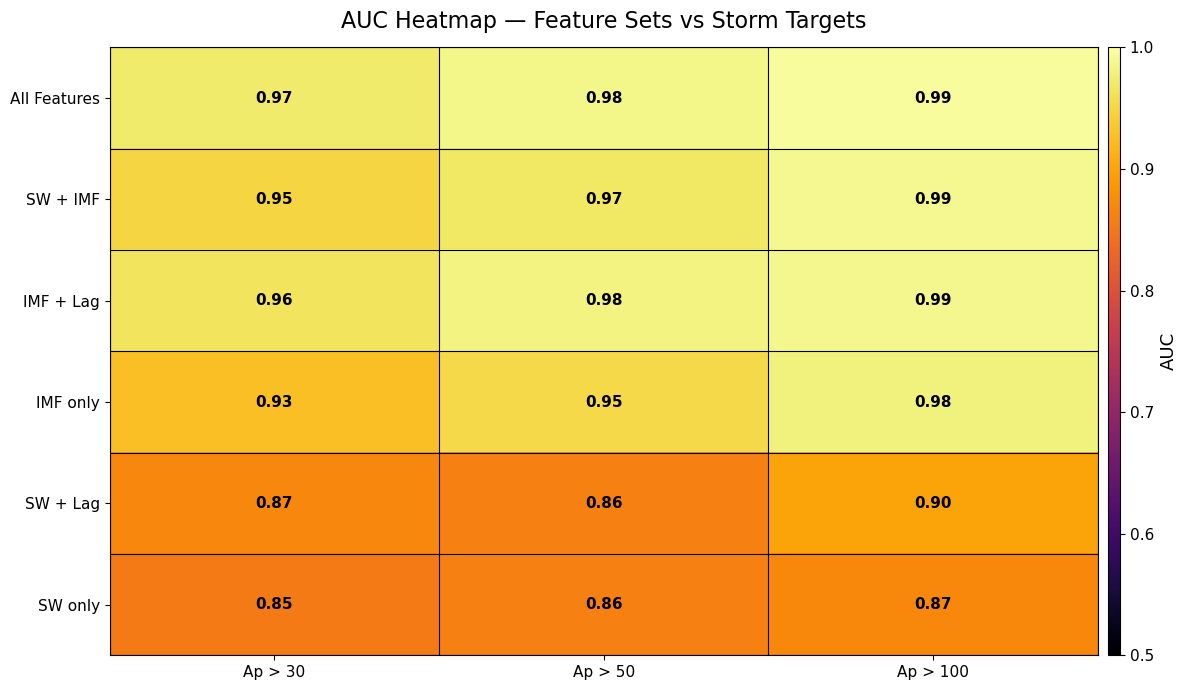

In [40]:
# AUC Heatmap
def plot_auc_heatmap(metrics_long):

    # Filter for valid AUC rows
    auc_df = metrics_long[(metrics_long["Metric"] == "AUC")].copy()

    # Pivot into matrix: Feature_Set × Target
    pivot = auc_df.pivot(
        index   = "Feature_Set",
        columns = "Target",
        values  = "Score"
    )
    
    desired_order = ["Ap > 30", "Ap > 50", "Ap > 100"]
    pivot = pivot.reindex(columns = desired_order)
    
    # Remove columns that contain no AUC values
    pivot = pivot.dropna(axis = 1, how = "all")

    if pivot.shape[1] == 0:
        print("No valid AUC values available for heatmap.")
        return

    # Sort rows by their best AUC (descending)
    pivot = pivot.loc[pivot.max(axis = 1).sort_values(ascending = False).index]

    # Mask NaN cells
    mask = pivot.isna()

    # Figure Setup
    plt.figure(figsize = (12, 7))

    cmap = plt.cm.inferno.copy()
    cmap.set_bad(color = "lightgray")     # Color for NaN cells

    # Heatmap
    im = plt.imshow(
        pivot,
        aspect = "auto",
        cmap   = cmap,
        vmin   = 0.50,
        vmax   = 1.00
    )

    # Colorbar
    cbar = plt.colorbar(im, pad = 0.01, fraction = 0.035, aspect = 50)
    cbar.set_label("AUC", fontsize = 13)
    cbar.ax.tick_params(labelsize = 11)

    # Axis Labels
    plt.xticks(ticks = np.arange(pivot.shape[1]), labels = pivot.columns, fontsize = 11)
    plt.yticks(ticks = np.arange(pivot.shape[0]), labels = pivot.index, fontsize = 11)
    plt.title("AUC Heatmap — Feature Sets vs Storm Targets", fontsize = 16, pad = 14)

    # Cell Annotations
    for i in range(pivot.shape[0]):        # rows
        for j in range(pivot.shape[1]):    # columns
            val = pivot.iloc[i, j]
            if not np.isnan(val):
                text_color = "white" if val < 0.80 else "black"
                plt.text(
                    j, i, f"{val:.2f}",
                    ha = "center",
                    va = "center",
                    fontsize = 11,
                    fontweight = "bold",
                    color = text_color
                )

    # Gridlines
    for x in np.arange(-0.5, pivot.shape[1], 1):
        plt.axvline(x = x, color = "black", lw = 0.8)

    for y in np.arange(-0.5, pivot.shape[0], 1):
        plt.axhline(y = y, color = "black", lw = 0.8)

    plt.tight_layout()
    plt.show()

# Run 
plot_auc_heatmap(metrics_long)

# SHAP Interpretation Guide

## 1. Mean SHAP (Global Importance)
**What it shows**  
- The average absolute SHAP value for each feature.  
- Higher bars indicate stronger overall influence on storm prediction.

**How to interpret**  
- Identifies the most important predictors.  
- Does not show direction (increase/decrease).  
- Does not show which value ranges matter.

---

## 2. SHAP Beeswarm (Global Behavior + Direction)
**What it shows**  
- Each point represents one sample.  
- Horizontal position = SHAP impact.  
- Color indicates actual feature value (blue = low, red = high).  
- Features are sorted by importance.

**How to interpret**  
- Right side → pushes prediction toward a storm.  
- Left side → pushes prediction away from a storm.  
- Red-right clusters → high values associated with storms.  
- Blue-right clusters → low values associated with storms.  
- Shows how real feature values influence the model.

---

## 3. SHAP Waterfall (Local Explanation)
**What it shows**  
- Feature contributions for a *single* prediction.  
- Bars represent how each feature increases or decreases the model’s output.

**How to interpret**  
- Positive bars push the prediction toward a storm.  
- Negative bars push the prediction away from a storm.  
- Explains why the model classified that specific event the way it did.

---

| Plot Type       | Scope   | Direction? | Shows Value? | Best Use |
|-----------------|---------|------------|--------------|----------|
| **Mean SHAP**   | Global  | No         | No           | Ranking overall importance |
| **Beeswarm**    | Global  | Yes        | Yes          | Understanding how feature values affect storms |
| **Waterfall**   | Local   | Yes        | Yes          | Explaining a single prediction |


SHAP Progress:   0%|                                  | 0/3 [00:00<?, ?target/s]


Generating SHAP plots for: Ap > 30



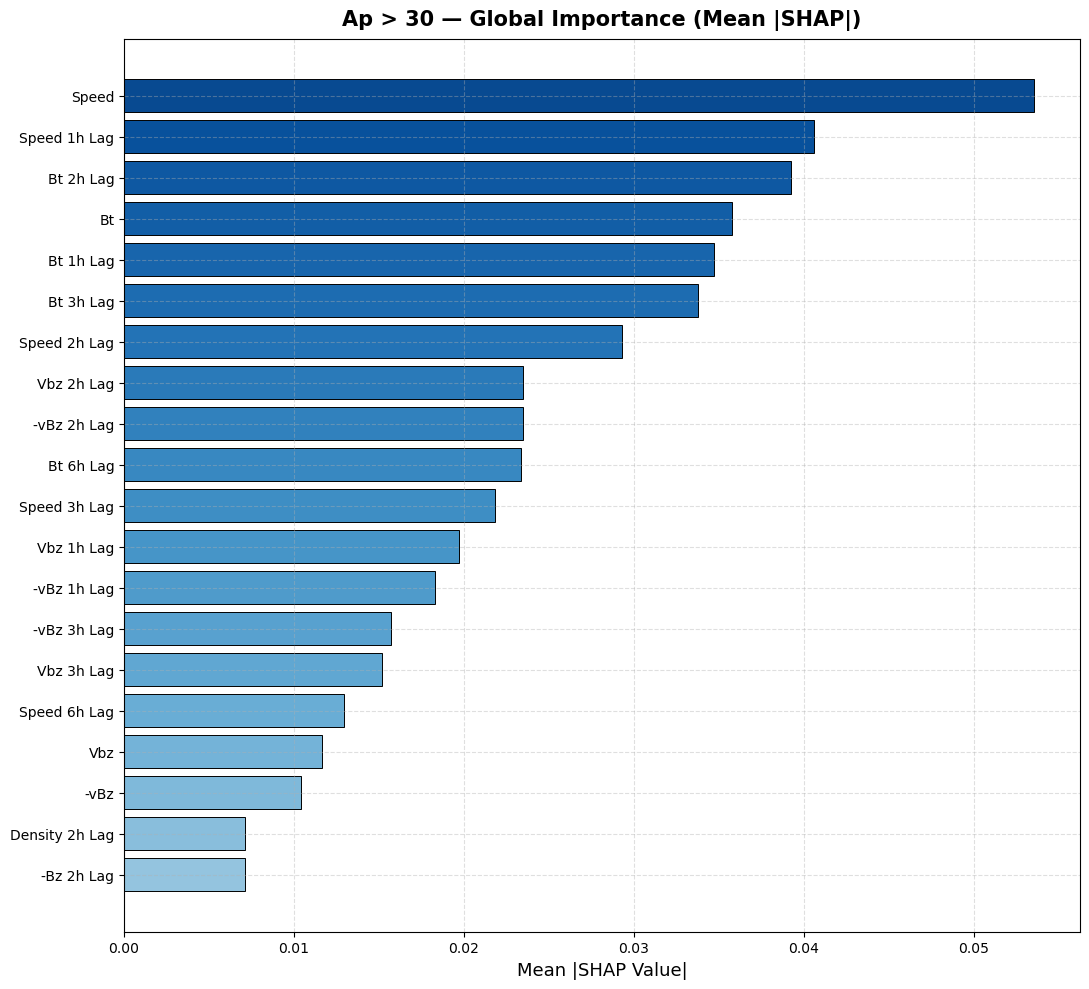

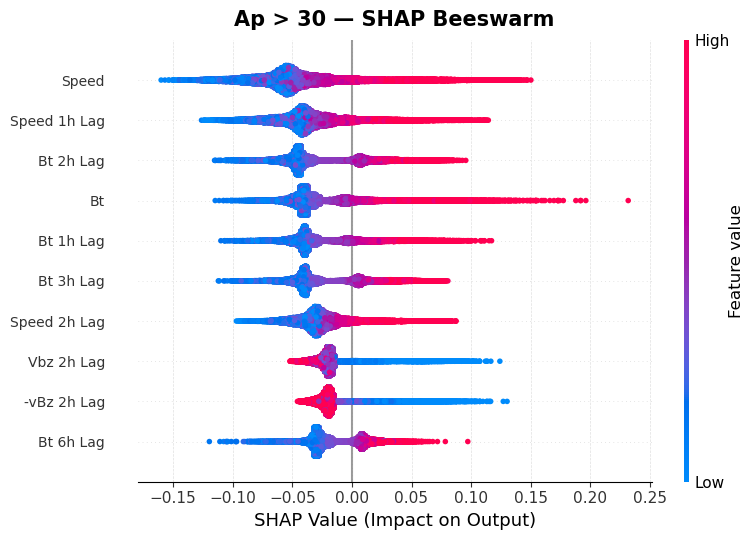

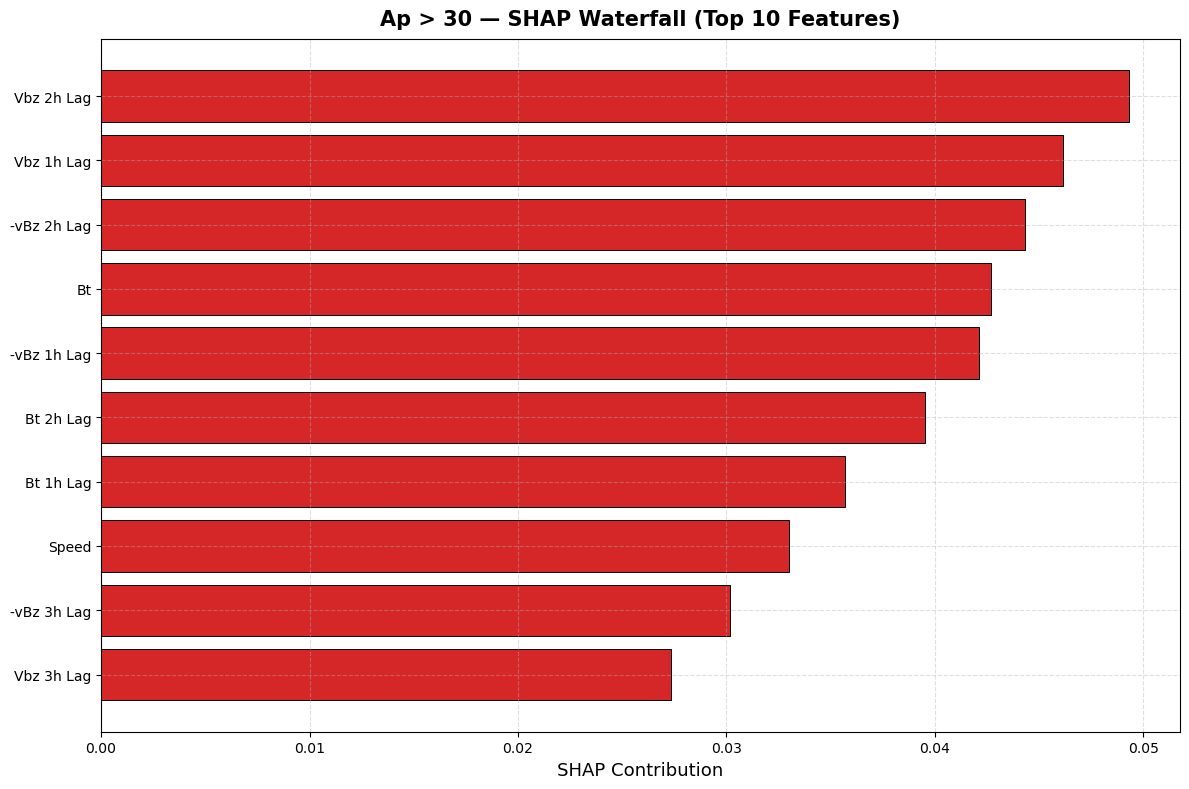

SHAP Progress:  33%|███████▎              | 1/3 [50:02<1:40:04, 3002.22s/target]

Finished SHAP plots for: Ap > 30


Generating SHAP plots for: Ap > 50



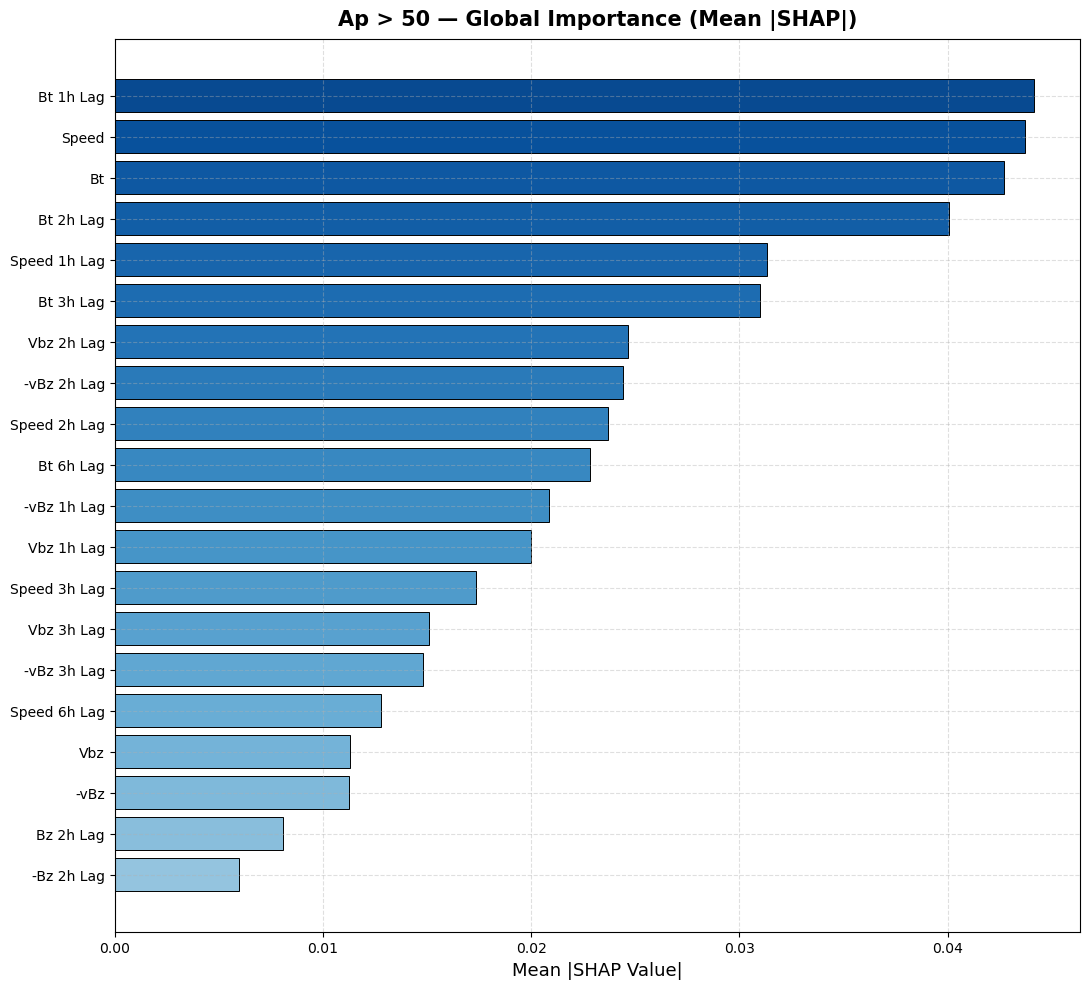

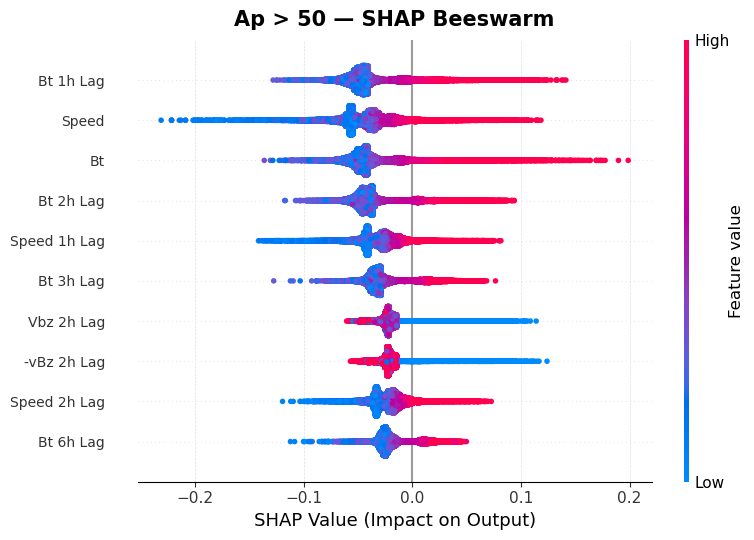

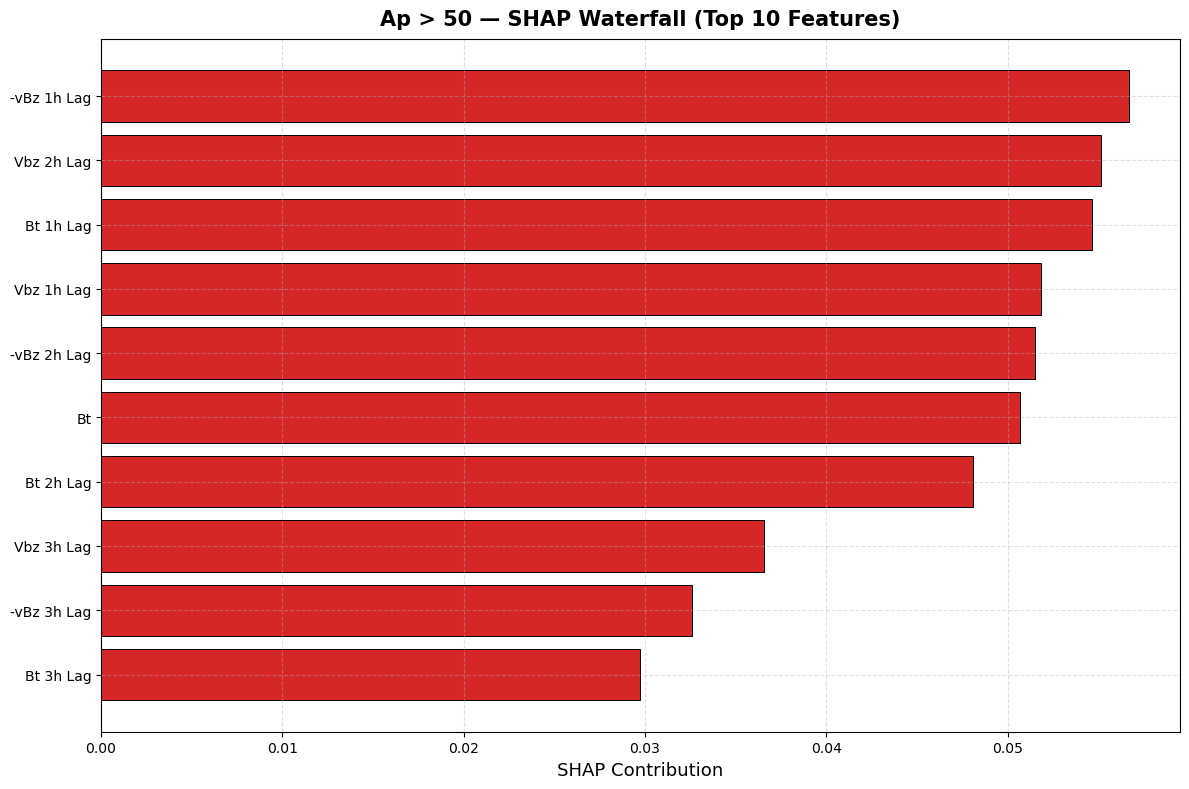

SHAP Progress:  67%|██████████████▋       | 2/3 [1:12:15<33:40, 2020.44s/target]

Finished SHAP plots for: Ap > 50


Generating SHAP plots for: Ap > 100



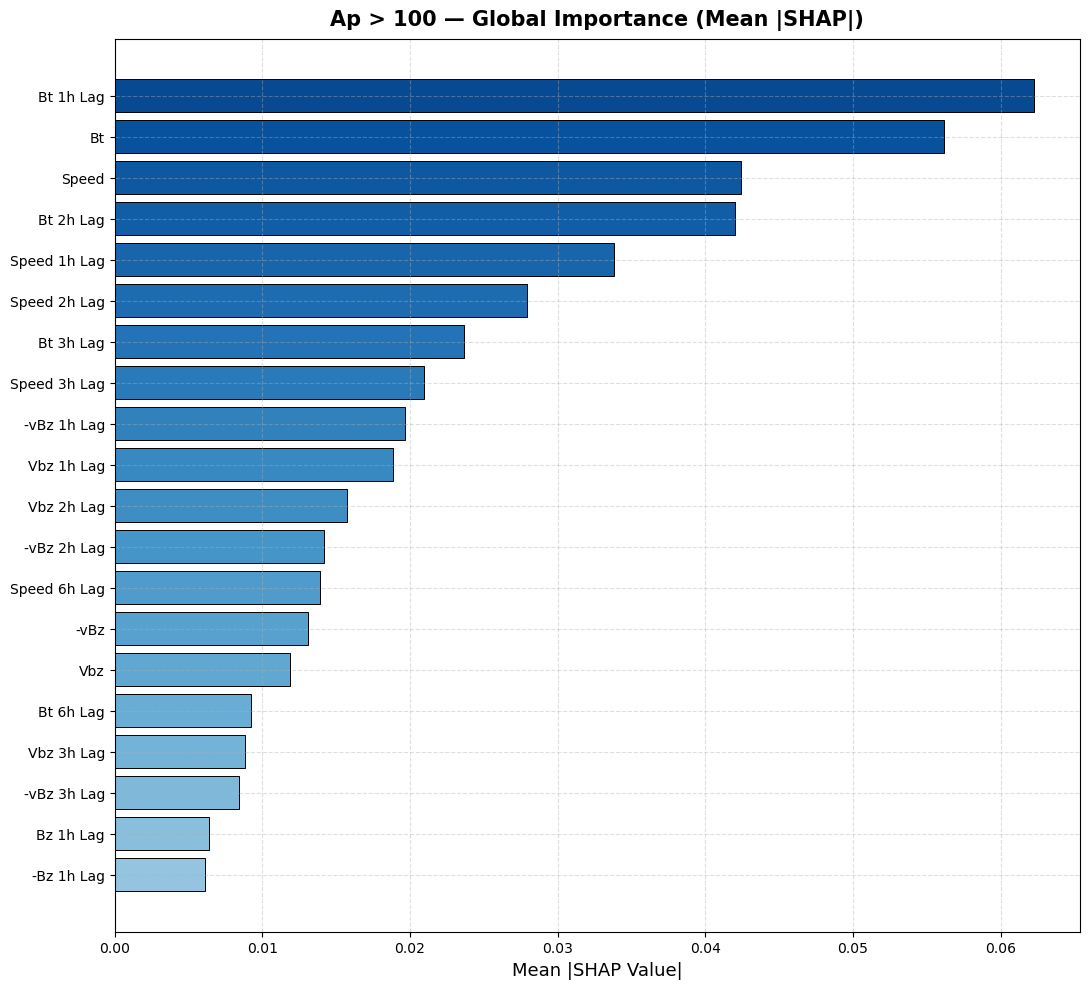

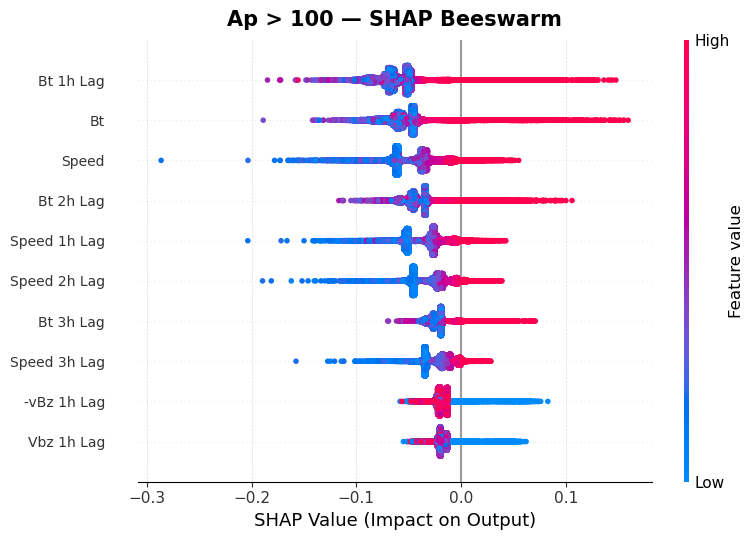

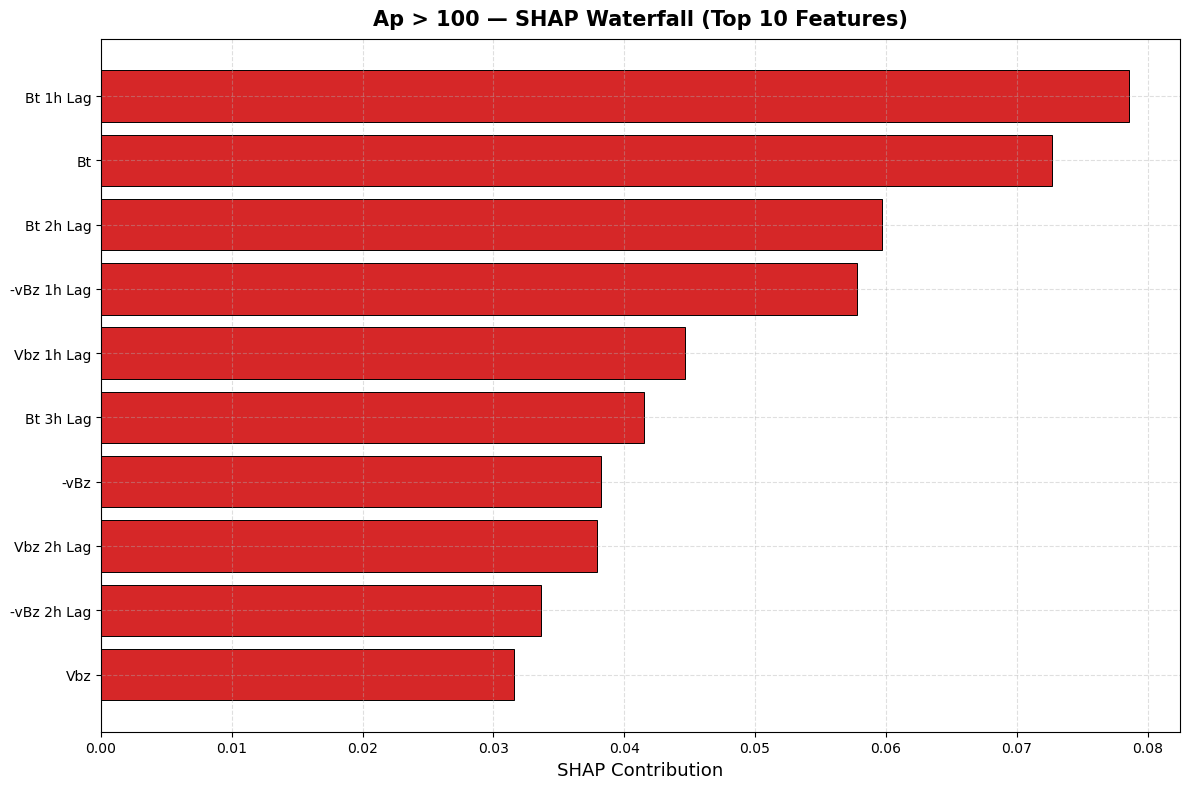

SHAP Progress: 100%|██████████████████████| 3/3 [1:18:38<00:00, 1572.79s/target]

Finished SHAP plots for: Ap > 100



In [41]:
# Create Mean SHAP (Global), Beeswarm and Waterfall
targets = [
    "storm_ap",
    "storm_ap50",
    "storm_ap100"
]

def pretty_target(label):
    if label == "storm_ap": return "Ap > 30"
    if label == "storm_ap50": return "Ap > 50"
    if label == "storm_ap100": return "Ap > 100"
    return label

# Cleaner feature names
def format_feature_name(name):
    """
    Convert:
        Bz_neg_lag24     -  -Bz 24h Lag
        vBz_neg_lag12    -  -vBz 12h Lag
        Density_lag6     -  Density 6h Lag
        Speed            -  Speed
    """
    # Lags
    if "_lag" in name:
        base, lag = name.split("_lag")
        lag = lag.replace(" ", "")
        lag_str = f"{lag}h Lag"

        base = base.strip()

        # Replace negative variants
        if base == "Bz_neg": 
            return f"-Bz {lag_str}"
        if base == "vBz_neg":
            return f"-vBz {lag_str}"

        # Regular variable with lag
        return f"{base.replace('_',' ').title()} {lag_str}"

    # Non-lag variables
    if name == "Bz_neg": return "-Bz"
    if name == "vBz_neg": return "-vBz"

    return name.replace("_", " ").title()


feature_set_name = "All Features"
fold_to_use = -1

for target_col in tqdm(targets, desc = "SHAP Progress", unit = "target"):

    nice_label = pretty_target(target_col)

    print("\n" + "="*90)
    print(f"Generating SHAP plots for: {nice_label}")
    print("="*90 + "\n")

    # Retrieve SHAP entry
    entry = SHAP_Store[target_col][feature_set_name][fold_to_use]

    model        = entry["model"]
    X_test       = entry["X_test"]
    feature_list = entry["feature_list"]

    # Apply cleaned names
    formatted_columns = [format_feature_name(c) for c in feature_list]
    X_test_v2 = pd.DataFrame(X_test, columns = formatted_columns)

    # Compute SHAP values
    explainer = shap.TreeExplainer(model)
    shap_vals = explainer.shap_values(X_test)

    if shap_vals.ndim == 3:
        shap_vals_use = shap_vals[:, :, 1]
    else:
        shap_vals_use = shap_vals[1] if isinstance(shap_vals, list) else shap_vals

    shap_vals_use = np.squeeze(shap_vals_use)

    # Waterfall: Top 10
    probs = model.predict_proba(X_test)[:, 1]
    sample_idx = np.argmax(probs)

    wf_df = pd.DataFrame({
        "Feature": feature_list,
        "Pretty": formatted_columns,
        "SHAP": shap_vals_use[sample_idx].tolist(),
        "Value": X_test[sample_idx].tolist(),
    }).sort_values("SHAP", ascending = False)

    wf_df_top = wf_df.iloc[:10]

    # Mean SHAP
    shap_means = np.abs(shap_vals_use).mean(axis = 0)

    shap_df = (
        pd.DataFrame({
            "Feature": formatted_columns,
            "MeanAbsSHAP": shap_means
        })
        .sort_values("MeanAbsSHAP", ascending = True)
        .tail(20)
    )

    # Global Mean SHAP
    plt.figure(figsize = (11, 10))
    plt.barh(shap_df["Feature"], shap_df["MeanAbsSHAP"], color = plt.cm.Blues(np.linspace(0.4, 0.9, len(shap_df))),
             edgecolor = "black", linewidth = 0.7)
    plt.title(f"{nice_label} — Global Importance (Mean |SHAP|)", fontsize = 15, fontweight = "bold", pad = 10)
    plt.xlabel("Mean |SHAP Value|", fontsize = 13)
    plt.grid(True, linestyle = "--", alpha = 0.4)
    plt.tight_layout()
    plt.show()

    # Beeswarm
    plt.figure(figsize = (11, 10))
    shap.summary_plot(shap_vals_use, X_test_v2, max_display = 10, color = plt.cm.plasma, show = False)
    ax = plt.gca()
    ax.set_title(f"{nice_label} — SHAP Beeswarm", fontsize = 15, fontweight = "bold", pad = 10)
    ax.set_xlabel("SHAP Value (Impact on Output)", fontsize = 13)
    ax.tick_params(axis = "y", labelsize = 10)
    ax.grid(True, linestyle = "--", linewidth = 0.5, alpha = 0.4, axis = "x")
    plt.tight_layout()
    plt.show()

    # Waterfall Plot
    plt.figure(figsize = (12, 8))
    colors = ["#d62728" if v > 0 else "#1f77b4" for v in wf_df_top["SHAP"]]
    plt.barh(wf_df_top["Pretty"], wf_df_top["SHAP"], color = colors, edgecolor = "black", linewidth = 0.7)
    plt.gca().invert_yaxis()
    plt.title(f"{nice_label} — SHAP Waterfall (Top 10 Features)", fontsize = 15, fontweight = "bold", pad = 10)
    plt.xlabel("SHAP Contribution", fontsize = 13)
    plt.grid(True, linestyle = "--", alpha = 0.4)
    plt.tight_layout()
    plt.show()

    print(f"Finished SHAP plots for: {nice_label}\n")

# Geomagnetic Storm Prediction Summary

This summary presents machine-learning results for geomagnetic storm prediction using corrected ACE IMF and solar-wind measurements. Storm categories are defined by hourly Ap values:

- **Ap > 30** (Minor–moderate storm)  
- **Ap > 50** (Strong storm)  
- **Ap > 100** (Major storm)

Models were trained using Random Forest classifiers with IMF variables, solar-wind parameters, and short-term lag features (1, 2, 3, and 6 hours). The preprocessing pipeline has been improved to correctly extract physical Bt from the ACE Bmag field and Bz from GSM coordinates. These corrections significantly improved model skill across all storm tiers.

---

## 1. Key Physical Drivers Identified by the Models

Across all storm categories, the model consistently identifies the same hierarchy of geoeffective drivers.

### Primary Drivers
1. **Southward IMF Bz (Bz_neg)**  
2. **IMF magnitude (Bt)**  
3. **Solar-wind speed**  
4. **Solar-wind density**  
5. **Short-term lag features (1–6 hours)**  

IMF structure provides the primary trigger, while solar-wind parameters amplify geoeffectiveness.

---

## 2. Feature Set Performance

Average AUC scores for each storm threshold:

### Ap > 30
- All Features: **0.9726**  
- IMF + Lag: **0.9647**  
- SW + IMF: **0.9477**  
- IMF only: **0.9261**  
- SW + Lag: **0.8687**  
- SW only: **0.8543**

### Ap > 50
- All Features: **0.9847**  
- IMF + Lag: **0.9812**  
- SW + IMF: **0.9674**  
- IMF only: **0.9526**  
- SW + Lag: **0.8613**  
- SW only: **0.8600**

### Ap > 100
- All Features: **0.9945**  
- SW + IMF: **0.9897**  
- IMF + Lag: **0.9882**  
- IMF only: **0.9796**  
- SW + Lag: **0.8998**  
- SW only: **0.8710**

Feature sets containing IMF structure (with or without lags) yield the highest AUCs for every storm class.

---

## 3. SHAP-Based Feature Importance

### Global Mean SHAP
- **Bz_neg**, **Bt**, and **vBz** are the strongest predictors.  
- Solar-wind **speed** contributes across all storm levels.  
- **Density** becomes more important for stronger storms.  
- Lag features capture persistence of southward IMF conditions.

### Beeswarm Patterns
- Negative Bz and strong Bt shift predictions toward storms.  
- High-speed streams amplify the effect of negative Bz.  
- Moderate to high densities align with compression and shock signatures.

### Local (Waterfall) Explanations
Individual storm events typically show leading contributions from negative Bz, high Bt, elevated speed, and recent lagged IMF values.

---

## 4. Interaction Effects

Pairwise interaction thresholds reveal storm-enhancing combinations:

- **Bz × Speed:** Negative Bz combined with elevated speed increases storm probability.  
- **Bt × Speed:** High IMF magnitude with fast solar wind is associated with Ap > 50 and Ap > 100.  
- **Speed × Density:** High speed with elevated density often indicates compression or CME shock arrival.

These interactions reflect established solar-wind–magnetosphere coupling processes.

---

## 5. Decision-Tree Threshold Behavior

Surrogate decision trees extracted from the Random Forest models show consistent physical patterns.

### Ap > 30
- Bz < 0  
- Moderate Bt  
- Solar-wind speed > 400–500 km/s

### Ap > 50
- Bt < −8 nT  
- Speed > 500–600 km/s

### Ap > 100
- Bt < −10 nT  
- Strongly negative Bz  
- Speed > 650 km/s  
- Density enhancements consistent with CME shocks

---

## 6. Operational Interpretation

### Storm Initiation
- Driven primarily by a southward turning of Bz and sufficient IMF magnitude.

### Storm Intensification
- Controlled by the duration of negative Bz, magnitude of Bt, and solar-wind compression from elevated density and high speed.

**Summary:**  
Geomagnetic storms require both strong IMF conditions and adequate solar-wind flow.  
Higher-level storms require stronger or more persistent versions of the same drivers.

---

## 7. Summary Table

| Storm Level | Primary Indicator | Secondary Indicator | Typical Threshold Combination |
|-------------|-------------------|----------------------|-------------------------------|
| **Ap > 30** | Bz southward      | Speed                | Bz < 0 and Speed > 400 km/s   |
| **Ap > 50** | Bt increase       | Negative Bz          | Bt < −8 nT and Speed > 500 km/s |
| **Ap > 100** | Extreme Bt        | Shock density        | Bt < −10 nT, Density > 10 cm⁻³, Speed > 650 km/s |

---

# End of Summary


In [42]:
# Define storming and variables to analyze
storm_targets = {
    "Ap > 30":   "storm_ap",
    "Ap > 50":   "storm_ap50",
    "Ap > 100":  "storm_ap100"
}

core_vars = ["Bz", "Bt", "Speed", "Density"]
pair_vars = [
    ("Bz","Bt"),
    ("Bz","Speed"),
    ("Bz","Density"),
    ("Bt","Speed"),
    ("Bt","Density"),
    ("Speed","Density")
]

In [43]:
# Function to evaluate thresholds using a single variable
def single_thresholds(df, feature, target, bins = 40):

    tmp = df[[feature, target]].dropna().copy()

    # Create numeric bins
    edges = np.linspace(tmp[feature].min(), tmp[feature].max(), bins + 1)
    tmp["bin"] = pd.cut(tmp[feature], edges, include_lowest = True)

    # Aggregate
    g = tmp.groupby("bin")[target].agg(["mean", "count"]).reset_index()

    # Drop empty bins
    g = g[g["count"] > 0].copy()

    # Safe numeric edges
    g["min"] = g["bin"].apply(lambda x: x.left)
    g["max"] = g["bin"].apply(lambda x: x.right)
    g["center"] = g["bin"].apply(lambda x: x.mid)

    return g[["center", "min", "max", "mean", "count"]].sort_values("center")

# Function to determine thresholds for paired variables
def paired_thresholds(df, x_var, y_var, target,
                             bins = 15, prob_thresh = 0.20, min_count = 40):

    tmp = df[[x_var, y_var, target]].dropna().copy()

    # Create numeric bin edges
    x_edges = np.linspace(tmp[x_var].min(), tmp[x_var].max(), bins + 1)
    y_edges = np.linspace(tmp[y_var].min(), tmp[y_var].max(), bins + 1)

    tmp["x_bin"] = pd.cut(tmp[x_var], x_edges, include_lowest = True)
    tmp["y_bin"] = pd.cut(tmp[y_var], y_edges, include_lowest = True)

    # Aggregate
    g = tmp.groupby(["x_bin", "y_bin"])[target].agg(["mean","count"]).reset_index()

    # Filter bins with enough samples and high storm probability
    high = g[(g["count"] >= min_count) & (g["mean"] >= prob_thresh)].copy()

    # Return empty dataframe if no thresholds met
    if high.empty:
        return high

    # Extract
    high["x_min"] = high["x_bin"].apply(lambda x: float(x.left))
    high["x_max"] = high["x_bin"].apply(lambda x: float(x.right))
    high["y_min"] = high["y_bin"].apply(lambda x: float(x.left))
    high["y_max"] = high["y_bin"].apply(lambda x: float(x.right))

    high.insert(0, "x_var", x_var)
    high.insert(1, "y_var", y_var)

    return high[[
        "x_var","y_var",
        "x_min","x_max","y_min","y_max",
        "mean","count"
    ]].sort_values("mean", ascending = False)

# Function to determine thresholds for multiple variables
def multivariate_thresholds(df, target, max_depth = 4):

    tmp = df[["Bz","Bt","Speed","Density", target]].dropna().copy()

    X = tmp[["Bz","Bt","Speed","Density"]]
    y = tmp[target]

    surrogate = DecisionTreeClassifier(
        max_depth = max_depth,
        min_samples_leaf = 150
    ).fit(X, y)

    rules = export_text(surrogate, feature_names = list(X.columns))
    return rules

In [46]:
# Create a new df variable to avoid corrupting the original
dfc = df.copy()

# Single Thresholds
single_Bz      = single_thresholds(dfc, "Bz",      "storm_ap")
single_Bt      = single_thresholds(dfc, "Bt",      "storm_ap")
single_Speed   = single_thresholds(dfc, "Speed",   "storm_ap")
single_Density = single_thresholds(dfc, "Density", "storm_ap")

single_Bz50      = single_thresholds(dfc, "Bz",      "storm_ap50")
single_Bt50      = single_thresholds(dfc, "Bt",      "storm_ap50")
single_Speed50   = single_thresholds(dfc, "Speed",   "storm_ap50")
single_Density50 = single_thresholds(dfc, "Density", "storm_ap50")

single_Bz100      = single_thresholds(dfc, "Bz",      "storm_ap100")
single_Bt100      = single_thresholds(dfc, "Bt",      "storm_ap100")
single_Speed100   = single_thresholds(dfc, "Speed",   "storm_ap100")
single_Density100 = single_thresholds(dfc, "Density", "storm_ap100")

# Paired Thresholds
pair_results = {}

for name, target in storm_targets.items():
    pair_results[name] = {}
    for (x, y) in pair_vars:
        res = paired_thresholds(dfc, x, y, target)
        pair_results[name][f"{x} × {y}"] = res

# Multiple Variable Thresholds
rules_ap30  = multivariate_thresholds(dfc, "storm_ap")
rules_ap50  = multivariate_thresholds(dfc, "storm_ap50")
rules_ap100 = multivariate_thresholds(dfc, "storm_ap100")

In [49]:
def generate_storm_report(df, storm_targets):

    report_lines = []

    for label, target_col in storm_targets.items():
        report_lines.append(f"# Storm Threshold Report — {label}")
        report_lines.append("")

        # Single-variable thresholds
        report_lines.append("## Single-Variable Thresholds")
        for v in core_vars:
            res = single_thresholds(df, v, target_col).head(10)
            report_lines.append(f"### {v}")
            report_lines.append(res.to_markdown(index = False))
            report_lines.append("")

        # Pairwise thresholds
        report_lines.append("## 2. Pairwise Interaction Thresholds")
        for (x, y) in pair_vars:
            res = paired_thresholds(df, x, y, target_col)
            report_lines.append(f"### {x} × {y}")
            if res.empty:
                report_lines.append("_No significant storm-producing regions found._\n")
            else:
                report_lines.append(res.head(10).to_markdown(index = False))
        report_lines.append("")

        # Multivariate rules
        report_lines.append("## Multivariate Threshold Rules (Bz, Bt, Speed, Density)")
        rules = multivariate_thresholds(df, target_col)
        report_lines.append("```\n" + rules + "\n```")
        report_lines.append("\n---\n")

    return "\n".join(report_lines)


In [50]:
# Generate report
storm_report = generate_storm_report(df, storm_targets)
display(Markdown(storm_report))

# Storm Threshold Report — Ap > 30

## Single-Variable Thresholds
### Bz
|   center |     min |     max |   mean |   count |
|---------:|--------:|--------:|-------:|--------:|
| -68.0865 | -69.566 | -66.607 |      1 |       1 |
| -50.338  | -51.817 | -48.859 |      1 |       2 |
| -47.38   | -48.859 | -45.901 |      1 |       2 |
| -44.422  | -45.901 | -42.943 |      1 |       4 |
| -41.4645 | -42.943 | -39.986 |      1 |       4 |
| -38.507  | -39.986 | -37.028 |      1 |       6 |
| -35.549  | -37.028 | -34.07  |      1 |       2 |
| -32.591  | -34.07  | -31.112 |      1 |       5 |
| -29.633  | -31.112 | -28.154 |      1 |      12 |
| -26.675  | -28.154 | -25.196 |      1 |      16 |

### Bt
|   center |    min |    max |       mean |   count |
|---------:|-------:|-------:|-----------:|--------:|
|   1.164  |  0.267 |  2.061 | 0          |    4808 |
|   2.9575 |  2.061 |  3.854 | 0.00146205 |   50614 |
|   4.7505 |  3.854 |  5.647 | 0.0149137  |   79055 |
|   6.5435 |  5.647 |  7.44  | 0.0544472  |   45714 |
|   8.337  |  7.44  |  9.234 | 0.105613   |   21238 |
|  10.1305 |  9.234 | 11.027 | 0.174926   |   10473 |
|  11.9235 | 11.027 | 12.82  | 0.265759   |    5140 |
|  13.7165 | 12.82  | 14.613 | 0.329368   |    2690 |
|  15.5095 | 14.613 | 16.406 | 0.440564   |    1489 |
|  17.3025 | 16.406 | 18.199 | 0.485556   |     900 |

### Speed
|   center |     min |     max |       mean |   count |
|---------:|--------:|--------:|-----------:|--------:|
|  239.544 | 227.539 | 251.549 | 0          |     100 |
|  263.553 | 251.549 | 275.558 | 0          |    1842 |
|  287.562 | 275.558 | 299.566 | 0          |    8563 |
|  311.57  | 299.566 | 323.575 | 0.00229575 |   14810 |
|  335.579 | 323.575 | 347.584 | 0.00573718 |   21962 |
|  359.588 | 347.584 | 371.592 | 0.0125161  |   27165 |
|  383.596 | 371.592 | 395.601 | 0.0197082  |   26182 |
|  407.606 | 395.601 | 419.61  | 0.029958   |   23099 |
|  431.615 | 419.61  | 443.619 | 0.0417826  |   19769 |
|  455.624 | 443.619 | 467.628 | 0.0556981  |   16374 |

### Density
|   center |    min |    max |      mean |   count |
|---------:|-------:|-------:|----------:|--------:|
|   1.364  |  0.06  |  2.668 | 0.0454055 |   37969 |
|   3.9715 |  2.668 |  5.275 | 0.0433941 |   86302 |
|   6.5785 |  5.275 |  7.882 | 0.0508601 |   47090 |
|   9.185  |  7.882 | 10.488 | 0.060686  |   24256 |
|  11.7915 | 10.488 | 13.095 | 0.0853701 |   11620 |
|  14.3985 | 13.095 | 15.702 | 0.0900327 |    6431 |
|  17.0055 | 15.702 | 18.309 | 0.106011  |    3660 |
|  19.6125 | 18.309 | 20.916 | 0.131616  |    2135 |
|  22.2195 | 20.916 | 23.523 | 0.148492  |    1293 |
|  24.826  | 23.523 | 26.129 | 0.149822  |     841 |

## 2. Pairwise Interaction Thresholds
### Bz × Bt
| x_var   | y_var   |   x_min |   x_max |   y_min |   y_max |     mean |   count |
|:--------|:--------|--------:|--------:|--------:|--------:|---------:|--------:|
| Bz      | Bt      | -22.238 | -14.35  |  24.176 |  28.958 | 1        |      46 |
| Bz      | Bt      | -22.238 | -14.35  |  19.395 |  24.176 | 0.965217 |     115 |
| Bz      | Bt      | -22.238 | -14.35  |  14.613 |  19.395 | 0.945205 |     146 |
| Bz      | Bt      | -14.35  |  -6.462 |  19.395 |  24.176 | 0.848739 |     119 |
| Bz      | Bt      |  -6.462 |   1.426 |  19.395 |  24.176 | 0.8      |     155 |
| Bz      | Bt      | -14.35  |  -6.462 |  14.613 |  19.395 | 0.790064 |     624 |
| Bz      | Bt      |  17.202 |  25.089 |  24.176 |  28.958 | 0.575    |      40 |
| Bz      | Bt      | -14.35  |  -6.462 |   9.831 |  14.613 | 0.515247 |    1902 |
| Bz      | Bt      |  -6.462 |   1.426 |  14.613 |  19.395 | 0.504551 |     769 |
| Bz      | Bt      |   1.426 |   9.314 |  19.395 |  24.176 | 0.5      |     126 |
### Bz × Speed
| x_var   | y_var   |   x_min |   x_max |   y_min |   y_max |     mean |   count |
|:--------|:--------|--------:|--------:|--------:|--------:|---------:|--------:|
| Bz      | Speed   | -22.238 | -14.35  | 483.633 | 547.657 | 1        |      56 |
| Bz      | Speed   | -22.238 | -14.35  | 547.657 | 611.68  | 1        |      40 |
| Bz      | Speed   | -14.35  |  -6.462 | 611.68  | 675.703 | 0.966667 |      90 |
| Bz      | Speed   | -22.238 | -14.35  | 419.61  | 483.633 | 0.95     |      60 |
| Bz      | Speed   | -22.238 | -14.35  | 355.587 | 419.61  | 0.943089 |     123 |
| Bz      | Speed   | -14.35  |  -6.462 | 547.657 | 611.68  | 0.931373 |     204 |
| Bz      | Speed   | -14.35  |  -6.462 | 675.703 | 739.727 | 0.9      |      50 |
| Bz      | Speed   | -14.35  |  -6.462 | 483.633 | 547.657 | 0.79375  |     480 |
| Bz      | Speed   |  -6.462 |   1.426 | 867.773 | 931.797 | 0.765957 |      47 |
| Bz      | Speed   |  -6.462 |   1.426 | 803.75  | 867.773 | 0.659864 |     147 |
### Bz × Density
| x_var   | y_var   |   x_min |   x_max |   y_min |   y_max |     mean |   count |
|:--------|:--------|--------:|--------:|--------:|--------:|---------:|--------:|
| Bz      | Density | -22.238 | -14.35  |   0.06  |   7.013 | 0.978417 |     139 |
| Bz      | Density | -22.238 | -14.35  |   7.013 |  13.964 | 0.95098  |     102 |
| Bz      | Density | -22.238 | -14.35  |  13.964 |  20.916 | 0.945455 |      55 |
| Bz      | Density | -14.35  |  -6.462 |  27.867 |  34.819 | 0.662921 |      89 |
| Bz      | Density | -14.35  |  -6.462 |  20.916 |  27.867 | 0.585106 |     188 |
| Bz      | Density | -14.35  |  -6.462 |   0.06  |   7.013 | 0.527127 |    1622 |
| Bz      | Density | -14.35  |  -6.462 |  13.964 |  20.916 | 0.521042 |     499 |
| Bz      | Density |  17.202 |  25.089 |   0.06  |   7.013 | 0.5      |      56 |
| Bz      | Density |  17.202 |  25.089 |   7.013 |  13.964 | 0.488372 |      43 |
| Bz      | Density | -14.35  |  -6.462 |   7.013 |  13.964 | 0.468966 |    1450 |
### Bt × Speed
| x_var   | y_var   |   x_min |   x_max |   y_min |   y_max |     mean |   count |
|:--------|:--------|--------:|--------:|--------:|--------:|---------:|--------:|
| Bt      | Speed   |  24.176 |  28.958 | 547.657 | 611.68  | 0.962264 |      53 |
| Bt      | Speed   |  19.395 |  24.176 | 611.68  | 675.703 | 0.926829 |      41 |
| Bt      | Speed   |  14.613 |  19.395 | 739.727 | 803.75  | 0.893617 |      47 |
| Bt      | Speed   |  19.395 |  24.176 | 483.633 | 547.657 | 0.828571 |     140 |
| Bt      | Speed   |  19.395 |  24.176 | 547.657 | 611.68  | 0.775281 |      89 |
| Bt      | Speed   |  14.613 |  19.395 | 675.703 | 739.727 | 0.759259 |      54 |
| Bt      | Speed   |   9.831 |  14.613 | 739.727 | 803.75  | 0.710145 |      69 |
| Bt      | Speed   |  14.613 |  19.395 | 611.68  | 675.703 | 0.701754 |     114 |
| Bt      | Speed   |   9.831 |  14.613 | 675.703 | 739.727 | 0.68     |     200 |
| Bt      | Speed   |   9.831 |  14.613 | 803.75  | 867.773 | 0.666667 |      42 |
### Bt × Density
| x_var   | y_var   |   x_min |   x_max |   y_min |   y_max |     mean |   count |
|:--------|:--------|--------:|--------:|--------:|--------:|---------:|--------:|
| Bt      | Density |  24.176 |  28.958 |   7.013 |  13.964 | 0.887097 |      62 |
| Bt      | Density |  24.176 |  28.958 |   0.06  |   7.013 | 0.864865 |      74 |
| Bt      | Density |  24.176 |  28.958 |  13.964 |  20.916 | 0.825    |      40 |
| Bt      | Density |  19.395 |  24.176 |  13.964 |  20.916 | 0.676692 |     133 |
| Bt      | Density |  19.395 |  24.176 |  20.916 |  27.867 | 0.672727 |      55 |
| Bt      | Density |  19.395 |  24.176 |   0.06  |   7.013 | 0.672131 |     244 |
| Bt      | Density |  19.395 |  24.176 |   7.013 |  13.964 | 0.622222 |     225 |
| Bt      | Density |  14.613 |  19.395 |  20.916 |  27.867 | 0.563981 |     211 |
| Bt      | Density |  14.613 |  19.395 |  27.867 |  34.819 | 0.54878  |      82 |
| Bt      | Density |  14.613 |  19.395 |   7.013 |  13.964 | 0.475921 |    1059 |
### Speed × Density
| x_var   | y_var   |   x_min |   x_max |   y_min |   y_max |     mean |   count |
|:--------|:--------|--------:|--------:|--------:|--------:|---------:|--------:|
| Speed   | Density | 931.797 | 995.82  |   0.06  |   7.013 | 1        |      51 |
| Speed   | Density | 867.773 | 931.797 |   0.06  |   7.013 | 0.744444 |      90 |
| Speed   | Density | 739.727 | 803.75  |   7.013 |  13.964 | 0.698413 |      63 |
| Speed   | Density | 675.703 | 739.727 |   7.013 |  13.964 | 0.624    |     125 |
| Speed   | Density | 611.68  | 675.703 |  13.964 |  20.916 | 0.605634 |      71 |
| Speed   | Density | 803.75  | 867.773 |   0.06  |   7.013 | 0.60274  |     219 |
| Speed   | Density | 483.633 | 547.657 |  20.916 |  27.867 | 0.594937 |      79 |
| Speed   | Density | 547.657 | 611.68  |  13.964 |  20.916 | 0.559524 |     252 |
| Speed   | Density | 739.727 | 803.75  |   0.06  |   7.013 | 0.53235  |     881 |
| Speed   | Density | 419.61  | 483.633 |  27.867 |  34.819 | 0.485981 |     107 |

## Multivariate Threshold Rules (Bz, Bt, Speed, Density)
```
|--- Bt <= 10.61
|   |--- Speed <= 567.43
|   |   |--- Bz <= -4.46
|   |   |   |--- Speed <= 426.68
|   |   |   |   |--- class: 0
|   |   |   |--- Speed >  426.68
|   |   |   |   |--- class: 0
|   |   |--- Bz >  -4.46
|   |   |   |--- Bt <= 7.48
|   |   |   |   |--- class: 0
|   |   |   |--- Bt >  7.48
|   |   |   |   |--- class: 0
|   |--- Speed >  567.43
|   |   |--- Bt <= 6.09
|   |   |   |--- Speed <= 685.89
|   |   |   |   |--- class: 0
|   |   |   |--- Speed >  685.89
|   |   |   |   |--- class: 0
|   |   |--- Bt >  6.09
|   |   |   |--- Bz <= -1.55
|   |   |   |   |--- class: 1
|   |   |   |--- Bz >  -1.55
|   |   |   |   |--- class: 0
|--- Bt >  10.61
|   |--- Bz <= -5.39
|   |   |--- Speed <= 398.85
|   |   |   |--- Bz <= -9.48
|   |   |   |   |--- class: 1
|   |   |   |--- Bz >  -9.48
|   |   |   |   |--- class: 0
|   |   |--- Speed >  398.85
|   |   |   |--- Bz <= -9.64
|   |   |   |   |--- class: 1
|   |   |   |--- Bz >  -9.64
|   |   |   |   |--- class: 1
|   |--- Bz >  -5.39
|   |   |--- Speed <= 516.48
|   |   |   |--- Speed <= 412.85
|   |   |   |   |--- class: 0
|   |   |   |--- Speed >  412.85
|   |   |   |   |--- class: 0
|   |   |--- Speed >  516.48
|   |   |   |--- Speed <= 630.87
|   |   |   |   |--- class: 0
|   |   |   |--- Speed >  630.87
|   |   |   |   |--- class: 1

```

---

# Storm Threshold Report — Ap > 50

## Single-Variable Thresholds
### Bz
|   center |     min |     max |   mean |   count |
|---------:|--------:|--------:|-------:|--------:|
| -68.0865 | -69.566 | -66.607 |      1 |       1 |
| -50.338  | -51.817 | -48.859 |      1 |       2 |
| -47.38   | -48.859 | -45.901 |      1 |       2 |
| -44.422  | -45.901 | -42.943 |      1 |       4 |
| -41.4645 | -42.943 | -39.986 |      1 |       4 |
| -38.507  | -39.986 | -37.028 |      1 |       6 |
| -35.549  | -37.028 | -34.07  |      1 |       2 |
| -32.591  | -34.07  | -31.112 |      1 |       5 |
| -29.633  | -31.112 | -28.154 |      1 |      12 |
| -26.675  | -28.154 | -25.196 |      1 |      16 |

### Bt
|   center |    min |    max |        mean |   count |
|---------:|-------:|-------:|------------:|--------:|
|   1.164  |  0.267 |  2.061 | 0           |    4808 |
|   2.9575 |  2.061 |  3.854 | 9.87869e-05 |   50614 |
|   4.7505 |  3.854 |  5.647 | 0.00126494  |   79055 |
|   6.5435 |  5.647 |  7.44  | 0.0101282   |   45714 |
|   8.337  |  7.44  |  9.234 | 0.0248611   |   21238 |
|  10.1305 |  9.234 | 11.027 | 0.055285    |   10473 |
|  11.9235 | 11.027 | 12.82  | 0.0892996   |    5140 |
|  13.7165 | 12.82  | 14.613 | 0.145725    |    2690 |
|  15.5095 | 14.613 | 16.406 | 0.235057    |    1489 |
|  17.3025 | 16.406 | 18.199 | 0.288889    |     900 |

### Speed
|   center |     min |     max |        mean |   count |
|---------:|--------:|--------:|------------:|--------:|
|  239.544 | 227.539 | 251.549 | 0           |     100 |
|  263.553 | 251.549 | 275.558 | 0           |    1842 |
|  287.562 | 275.558 | 299.566 | 0           |    8563 |
|  311.57  | 299.566 | 323.575 | 0.000270088 |   14810 |
|  335.579 | 323.575 | 347.584 | 0.000682998 |   21962 |
|  359.588 | 347.584 | 371.592 | 0.00338671  |   27165 |
|  383.596 | 371.592 | 395.601 | 0.00664579  |   26182 |
|  407.606 | 395.601 | 419.61  | 0.00904801  |   23099 |
|  431.615 | 419.61  | 443.619 | 0.0109768   |   19769 |
|  455.624 | 443.619 | 467.628 | 0.0174667   |   16374 |

### Density
|   center |    min |    max |      mean |   count |
|---------:|-------:|-------:|----------:|--------:|
|   1.364  |  0.06  |  2.668 | 0.0128263 |   37969 |
|   3.9715 |  2.668 |  5.275 | 0.0112744 |   86302 |
|   6.5785 |  5.275 |  7.882 | 0.0161181 |   47090 |
|   9.185  |  7.882 | 10.488 | 0.0213143 |   24256 |
|  11.7915 | 10.488 | 13.095 | 0.0317556 |   11620 |
|  14.3985 | 13.095 | 15.702 | 0.0377857 |    6431 |
|  17.0055 | 15.702 | 18.309 | 0.0464481 |    3660 |
|  19.6125 | 18.309 | 20.916 | 0.0552693 |    2135 |
|  22.2195 | 20.916 | 23.523 | 0.0734725 |    1293 |
|  24.826  | 23.523 | 26.129 | 0.0689655 |     841 |

## 2. Pairwise Interaction Thresholds
### Bz × Bt
| x_var   | y_var   |   x_min |   x_max |   y_min |   y_max |     mean |   count |
|:--------|:--------|--------:|--------:|--------:|--------:|---------:|--------:|
| Bz      | Bt      | -22.238 | -14.35  |  24.176 |  28.958 | 0.956522 |      46 |
| Bz      | Bt      | -22.238 | -14.35  |  19.395 |  24.176 | 0.913043 |     115 |
| Bz      | Bt      | -22.238 | -14.35  |  14.613 |  19.395 | 0.739726 |     146 |
| Bz      | Bt      | -14.35  |  -6.462 |  19.395 |  24.176 | 0.638655 |     119 |
| Bz      | Bt      | -14.35  |  -6.462 |  14.613 |  19.395 | 0.516026 |     624 |
| Bz      | Bt      |  -6.462 |   1.426 |  19.395 |  24.176 | 0.490323 |     155 |
| Bz      | Bt      |  17.202 |  25.089 |  24.176 |  28.958 | 0.275    |      40 |
| Bz      | Bt      |  -6.462 |   1.426 |  14.613 |  19.395 | 0.274382 |     769 |
| Bz      | Bt      |   1.426 |   9.314 |  19.395 |  24.176 | 0.261905 |     126 |
| Bz      | Bt      |   9.314 |  17.202 |  19.395 |  24.176 | 0.229814 |     161 |
### Bz × Speed
| x_var   | y_var   |   x_min |   x_max |   y_min |   y_max |     mean |   count |
|:--------|:--------|--------:|--------:|--------:|--------:|---------:|--------:|
| Bz      | Speed   | -22.238 | -14.35  | 547.657 | 611.68  | 1        |      40 |
| Bz      | Speed   | -22.238 | -14.35  | 483.633 | 547.657 | 0.946429 |      56 |
| Bz      | Speed   | -22.238 | -14.35  | 419.61  | 483.633 | 0.816667 |      60 |
| Bz      | Speed   | -14.35  |  -6.462 | 675.703 | 739.727 | 0.8      |      50 |
| Bz      | Speed   | -14.35  |  -6.462 | 611.68  | 675.703 | 0.788889 |      90 |
| Bz      | Speed   | -22.238 | -14.35  | 355.587 | 419.61  | 0.731707 |     123 |
| Bz      | Speed   | -14.35  |  -6.462 | 547.657 | 611.68  | 0.710784 |     204 |
| Bz      | Speed   |  -6.462 |   1.426 | 867.773 | 931.797 | 0.553191 |      47 |
| Bz      | Speed   | -14.35  |  -6.462 | 483.633 | 547.657 | 0.454167 |     480 |
| Bz      | Speed   |  -6.462 |   1.426 | 803.75  | 867.773 | 0.414966 |     147 |
### Bz × Density
| x_var   | y_var   |   x_min |   x_max |   y_min |   y_max |     mean |   count |
|:--------|:--------|--------:|--------:|--------:|--------:|---------:|--------:|
| Bz      | Density | -22.238 | -14.35  |   0.06  |   7.013 | 0.870504 |     139 |
| Bz      | Density | -22.238 | -14.35  |  13.964 |  20.916 | 0.836364 |      55 |
| Bz      | Density | -22.238 | -14.35  |   7.013 |  13.964 | 0.813725 |     102 |
| Bz      | Density | -14.35  |  -6.462 |  27.867 |  34.819 | 0.382022 |      89 |
| Bz      | Density | -14.35  |  -6.462 |  20.916 |  27.867 | 0.361702 |     188 |
| Bz      | Density |  17.202 |  25.089 |   7.013 |  13.964 | 0.27907  |      43 |
| Bz      | Density | -14.35  |  -6.462 |  13.964 |  20.916 | 0.268537 |     499 |
| Bz      | Density | -14.35  |  -6.462 |   0.06  |   7.013 | 0.266338 |    1622 |
| Bz      | Density |   9.314 |  17.202 |  27.867 |  34.819 | 0.234043 |      47 |
| Bz      | Density |  17.202 |  25.089 |   0.06  |   7.013 | 0.232143 |      56 |
### Bt × Speed
| x_var   | y_var   |   x_min |   x_max |   y_min |   y_max |     mean |   count |
|:--------|:--------|--------:|--------:|--------:|--------:|---------:|--------:|
| Bt      | Speed   |  24.176 |  28.958 | 547.657 | 611.68  | 0.830189 |      53 |
| Bt      | Speed   |  19.395 |  24.176 | 611.68  | 675.703 | 0.731707 |      41 |
| Bt      | Speed   |  14.613 |  19.395 | 739.727 | 803.75  | 0.595745 |      47 |
| Bt      | Speed   |  19.395 |  24.176 | 547.657 | 611.68  | 0.595506 |      89 |
| Bt      | Speed   |  19.395 |  24.176 | 483.633 | 547.657 | 0.557143 |     140 |
| Bt      | Speed   |  14.613 |  19.395 | 675.703 | 739.727 | 0.555556 |      54 |
| Bt      | Speed   |   9.831 |  14.613 | 803.75  | 867.773 | 0.52381  |      42 |
| Bt      | Speed   |   9.831 |  14.613 | 739.727 | 803.75  | 0.478261 |      69 |
| Bt      | Speed   |  14.613 |  19.395 | 611.68  | 675.703 | 0.473684 |     114 |
| Bt      | Speed   |   9.831 |  14.613 | 675.703 | 739.727 | 0.415    |     200 |
### Bt × Density
| x_var   | y_var   |   x_min |   x_max |   y_min |   y_max |     mean |   count |
|:--------|:--------|--------:|--------:|--------:|--------:|---------:|--------:|
| Bt      | Density |  24.176 |  28.958 |   7.013 |  13.964 | 0.693548 |      62 |
| Bt      | Density |  24.176 |  28.958 |  13.964 |  20.916 | 0.65     |      40 |
| Bt      | Density |  24.176 |  28.958 |   0.06  |   7.013 | 0.648649 |      74 |
| Bt      | Density |  19.395 |  24.176 |  20.916 |  27.867 | 0.509091 |      55 |
| Bt      | Density |  19.395 |  24.176 |  13.964 |  20.916 | 0.488722 |     133 |
| Bt      | Density |  19.395 |  24.176 |   0.06  |   7.013 | 0.454918 |     244 |
| Bt      | Density |  19.395 |  24.176 |   7.013 |  13.964 | 0.422222 |     225 |
| Bt      | Density |  14.613 |  19.395 |  27.867 |  34.819 | 0.341463 |      82 |
| Bt      | Density |  14.613 |  19.395 |   0.06  |   7.013 | 0.305459 |     861 |
| Bt      | Density |  14.613 |  19.395 |  20.916 |  27.867 | 0.293839 |     211 |
### Speed × Density
| x_var   | y_var   |   x_min |   x_max |   y_min |   y_max |     mean |   count |
|:--------|:--------|--------:|--------:|--------:|--------:|---------:|--------:|
| Speed   | Density | 931.797 | 995.82  |   0.06  |   7.013 | 0.901961 |      51 |
| Speed   | Density | 739.727 | 803.75  |   7.013 |  13.964 | 0.603175 |      63 |
| Speed   | Density | 867.773 | 931.797 |   0.06  |   7.013 | 0.588889 |      90 |
| Speed   | Density | 675.703 | 739.727 |   7.013 |  13.964 | 0.424    |     125 |
| Speed   | Density | 483.633 | 547.657 |  20.916 |  27.867 | 0.392405 |      79 |
| Speed   | Density | 803.75  | 867.773 |   0.06  |   7.013 | 0.374429 |     219 |
| Speed   | Density | 611.68  | 675.703 |  13.964 |  20.916 | 0.352113 |      71 |
| Speed   | Density | 547.657 | 611.68  |  13.964 |  20.916 | 0.321429 |     252 |
| Speed   | Density | 611.68  | 675.703 |   7.013 |  13.964 | 0.280669 |     538 |
| Speed   | Density | 419.61  | 483.633 |  27.867 |  34.819 | 0.214953 |     107 |

## Multivariate Threshold Rules (Bz, Bt, Speed, Density)
```
|--- Bt <= 14.75
|   |--- Bz <= -5.85
|   |   |--- Speed <= 550.50
|   |   |   |--- Speed <= 450.57
|   |   |   |   |--- class: 0
|   |   |   |--- Speed >  450.57
|   |   |   |   |--- class: 0
|   |   |--- Speed >  550.50
|   |   |   |--- Bt <= 11.06
|   |   |   |   |--- class: 1
|   |   |   |--- Bt >  11.06
|   |   |   |   |--- class: 1
|   |--- Bz >  -5.85
|   |   |--- Speed <= 688.89
|   |   |   |--- Bt <= 9.26
|   |   |   |   |--- class: 0
|   |   |   |--- Bt >  9.26
|   |   |   |   |--- class: 0
|   |   |--- Speed >  688.89
|   |   |   |--- Bt <= 7.25
|   |   |   |   |--- class: 0
|   |   |   |--- Bt >  7.25
|   |   |   |   |--- class: 0
|--- Bt >  14.75
|   |--- Bz <= -8.33
|   |   |--- Speed <= 435.47
|   |   |   |--- Bz <= -13.89
|   |   |   |   |--- class: 1
|   |   |   |--- Bz >  -13.89
|   |   |   |   |--- class: 0
|   |   |--- Speed >  435.47
|   |   |   |--- Bz <= -12.41
|   |   |   |   |--- class: 1
|   |   |   |--- Bz >  -12.41
|   |   |   |   |--- class: 1
|   |--- Bz >  -8.33
|   |   |--- Speed <= 527.32
|   |   |   |--- Bz <= -0.23
|   |   |   |   |--- class: 0
|   |   |   |--- Bz >  -0.23
|   |   |   |   |--- class: 0
|   |   |--- Speed >  527.32
|   |   |   |--- Bt <= 22.07
|   |   |   |   |--- class: 0
|   |   |   |--- Bt >  22.07
|   |   |   |   |--- class: 1

```

---

# Storm Threshold Report — Ap > 100

## Single-Variable Thresholds
### Bz
|   center |     min |     max |     mean |   count |
|---------:|--------:|--------:|---------:|--------:|
| -68.0865 | -69.566 | -66.607 | 1        |       1 |
| -50.338  | -51.817 | -48.859 | 1        |       2 |
| -47.38   | -48.859 | -45.901 | 1        |       2 |
| -44.422  | -45.901 | -42.943 | 1        |       4 |
| -41.4645 | -42.943 | -39.986 | 1        |       4 |
| -38.507  | -39.986 | -37.028 | 1        |       6 |
| -35.549  | -37.028 | -34.07  | 1        |       2 |
| -32.591  | -34.07  | -31.112 | 1        |       5 |
| -29.633  | -31.112 | -28.154 | 0.916667 |      12 |
| -26.675  | -28.154 | -25.196 | 1        |      16 |

### Bt
|   center |    min |    max |        mean |   count |
|---------:|-------:|-------:|------------:|--------:|
|   1.164  |  0.267 |  2.061 | 0           |    4808 |
|   2.9575 |  2.061 |  3.854 | 3.95148e-05 |   50614 |
|   4.7505 |  3.854 |  5.647 | 5.05977e-05 |   79055 |
|   6.5435 |  5.647 |  7.44  | 0.000459378 |   45714 |
|   8.337  |  7.44  |  9.234 | 0.00169507  |   21238 |
|  10.1305 |  9.234 | 11.027 | 0.00572902  |   10473 |
|  11.9235 | 11.027 | 12.82  | 0.0116732   |    5140 |
|  13.7165 | 12.82  | 14.613 | 0.032342    |    2690 |
|  15.5095 | 14.613 | 16.406 | 0.0496978   |    1489 |
|  17.3025 | 16.406 | 18.199 | 0.102222    |     900 |

### Speed
|   center |     min |     max |        mean |   count |
|---------:|--------:|--------:|------------:|--------:|
|  239.544 | 227.539 | 251.549 | 0           |     100 |
|  263.553 | 251.549 | 275.558 | 0           |    1842 |
|  287.562 | 275.558 | 299.566 | 0           |    8563 |
|  311.57  | 299.566 | 323.575 | 0           |   14810 |
|  335.579 | 323.575 | 347.584 | 0           |   21962 |
|  359.588 | 347.584 | 371.592 | 0.000368121 |   27165 |
|  383.596 | 371.592 | 395.601 | 0.00145138  |   26182 |
|  407.606 | 395.601 | 419.61  | 0.00129876  |   23099 |
|  431.615 | 419.61  | 443.619 | 0.00166928  |   19769 |
|  455.624 | 443.619 | 467.628 | 0.00225968  |   16374 |

### Density
|   center |    min |    max |       mean |   count |
|---------:|-------:|-------:|-----------:|--------:|
|   1.364  |  0.06  |  2.668 | 0.00260739 |   37969 |
|   3.9715 |  2.668 |  5.275 | 0.00214364 |   86302 |
|   6.5785 |  5.275 |  7.882 | 0.00297303 |   47090 |
|   9.185  |  7.882 | 10.488 | 0.00478232 |   24256 |
|  11.7915 | 10.488 | 13.095 | 0.00757315 |   11620 |
|  14.3985 | 13.095 | 15.702 | 0.00886332 |    6431 |
|  17.0055 | 15.702 | 18.309 | 0.0142077  |    3660 |
|  19.6125 | 18.309 | 20.916 | 0.0187354  |    2135 |
|  22.2195 | 20.916 | 23.523 | 0.0201083  |    1293 |
|  24.826  | 23.523 | 26.129 | 0.0237812  |     841 |

## 2. Pairwise Interaction Thresholds
### Bz × Bt
| x_var   | y_var   |   x_min |   x_max |   y_min |   y_max |     mean |   count |
|:--------|:--------|--------:|--------:|--------:|--------:|---------:|--------:|
| Bz      | Bt      | -22.238 | -14.35  |  24.176 |  28.958 | 0.673913 |      46 |
| Bz      | Bt      | -22.238 | -14.35  |  19.395 |  24.176 | 0.513043 |     115 |
| Bz      | Bt      | -22.238 | -14.35  |  14.613 |  19.395 | 0.328767 |     146 |
| Bz      | Bt      | -14.35  |  -6.462 |  19.395 |  24.176 | 0.327731 |     119 |
### Bz × Speed
| x_var   | y_var   |   x_min |   x_max |   y_min |   y_max |     mean |   count |
|:--------|:--------|--------:|--------:|--------:|--------:|---------:|--------:|
| Bz      | Speed   | -22.238 | -14.35  | 547.657 | 611.68  | 0.75     |      40 |
| Bz      | Speed   | -22.238 | -14.35  | 483.633 | 547.657 | 0.625    |      56 |
| Bz      | Speed   | -14.35  |  -6.462 | 675.703 | 739.727 | 0.6      |      50 |
| Bz      | Speed   | -22.238 | -14.35  | 419.61  | 483.633 | 0.4      |      60 |
| Bz      | Speed   | -14.35  |  -6.462 | 611.68  | 675.703 | 0.333333 |      90 |
| Bz      | Speed   |  -6.462 |   1.426 | 867.773 | 931.797 | 0.297872 |      47 |
| Bz      | Speed   | -22.238 | -14.35  | 355.587 | 419.61  | 0.219512 |     123 |
| Bz      | Speed   | -14.35  |  -6.462 | 547.657 | 611.68  | 0.205882 |     204 |
### Bz × Density
| x_var   | y_var   |   x_min |   x_max |   y_min |   y_max |     mean |   count |
|:--------|:--------|--------:|--------:|--------:|--------:|---------:|--------:|
| Bz      | Density | -22.238 |  -14.35 |   0.06  |   7.013 | 0.52518  |     139 |
| Bz      | Density | -22.238 |  -14.35 |  13.964 |  20.916 | 0.509091 |      55 |
| Bz      | Density | -22.238 |  -14.35 |   7.013 |  13.964 | 0.392157 |     102 |
### Bt × Speed
| x_var   | y_var   |   x_min |   x_max |   y_min |   y_max |     mean |   count |
|:--------|:--------|--------:|--------:|--------:|--------:|---------:|--------:|
| Bt      | Speed   |  24.176 |  28.958 | 547.657 | 611.68  | 0.45283  |      53 |
| Bt      | Speed   |  19.395 |  24.176 | 611.68  | 675.703 | 0.341463 |      41 |
| Bt      | Speed   |  19.395 |  24.176 | 547.657 | 611.68  | 0.314607 |      89 |
| Bt      | Speed   |  19.395 |  24.176 | 483.633 | 547.657 | 0.271429 |     140 |
| Bt      | Speed   |   9.831 |  14.613 | 803.75  | 867.773 | 0.261905 |      42 |
| Bt      | Speed   |  14.613 |  19.395 | 675.703 | 739.727 | 0.259259 |      54 |
| Bt      | Speed   |  14.613 |  19.395 | 739.727 | 803.75  | 0.255319 |      47 |
| Bt      | Speed   |   9.831 |  14.613 | 739.727 | 803.75  | 0.217391 |      69 |
### Bt × Density
| x_var   | y_var   |   x_min |   x_max |   y_min |   y_max |     mean |   count |
|:--------|:--------|--------:|--------:|--------:|--------:|---------:|--------:|
| Bt      | Density |  24.176 |  28.958 |   0.06  |   7.013 | 0.459459 |      74 |
| Bt      | Density |  24.176 |  28.958 |   7.013 |  13.964 | 0.419355 |      62 |
| Bt      | Density |  24.176 |  28.958 |  13.964 |  20.916 | 0.4      |      40 |
| Bt      | Density |  19.395 |  24.176 |  20.916 |  27.867 | 0.272727 |      55 |
| Bt      | Density |  19.395 |  24.176 |  13.964 |  20.916 | 0.225564 |     133 |
| Bt      | Density |  19.395 |  24.176 |   0.06  |   7.013 | 0.204918 |     244 |
### Speed × Density
| x_var   | y_var   |   x_min |   x_max |   y_min |   y_max |     mean |   count |
|:--------|:--------|--------:|--------:|--------:|--------:|---------:|--------:|
| Speed   | Density | 931.797 | 995.82  |   0.06  |   7.013 | 0.588235 |      51 |
| Speed   | Density | 867.773 | 931.797 |   0.06  |   7.013 | 0.377778 |      90 |
| Speed   | Density | 739.727 | 803.75  |   7.013 |  13.964 | 0.285714 |      63 |

## Multivariate Threshold Rules (Bz, Bt, Speed, Density)
```
|--- Bt <= 21.91
|   |--- Bz <= -13.76
|   |   |--- class: 0
|   |--- Bz >  -13.76
|   |   |--- Speed <= 831.44
|   |   |   |--- Bt <= 13.29
|   |   |   |   |--- class: 0
|   |   |   |--- Bt >  13.29
|   |   |   |   |--- class: 0
|   |   |--- Speed >  831.44
|   |   |   |--- class: 0
|--- Bt >  21.91
|   |--- Speed <= 523.81
|   |   |--- class: 0
|   |--- Speed >  523.81
|   |   |--- Bz <= -2.42
|   |   |   |--- class: 1
|   |   |--- Bz >  -2.42
|   |   |   |--- class: 0

```

---


# Summary of Geomagnetic Storm Thresholds  
Updated with Corrected IMF (Bt, Bz) and Solar-Wind Measurements  
Dataset: 1999–2025 ACE IMF & SWPC Solar Wind

---

## 1. Single-Variable Thresholds

These describe where the fraction of storm hours increases, based on binned probabilities.

### Ap > 30 (Minor–Moderate Storms)

| Variable | Threshold Region (Corrected)           | Interpretation                                                        |
|----------|----------------------------------------|----------------------------------------------------------------------|
| **Bt**   | **Bt > 10 nT**                         | Storm probability rises sharply (0.17 → 0.48).                      |
|          | **Bt > 14 nT**                         | CME magnetic clouds; high storm occurrence.                         |
| **Speed**| **> 450 km/s**                         | Storm fraction begins increasing.                                    |
|          | **> 550 km/s**                         | CME sheaths / high-speed streams dominate.                          |
| **Density** | **> 10 cm⁻³**                       | Compression supports Ap > 30 events.                                 |
|            | **> 15–20 cm⁻³**                     | Strong sheath compression.                                           |
| **Bz**     | **< –10 to –20 nT** (rare bins)      | Strong storms but sample sizes small; Bt and speed dominate.         |

---

### Ap > 50 (Moderate–Strong Storms)

| Variable | Threshold Region                         | Interpretation                                                   |
|----------|-------------------------------------------|------------------------------------------------------------------|
| **Bt**   | **Bt > 10–12 nT**                         | Majority of hours in these bins are storm hours.                |
| **Speed**| **> 550–600 km/s**                        | Clear rise in storm likelihood.                                 |
| **Density** | **> 10–15 cm⁻³**                       | Compression boosts Ap > 50; typical of CME sheaths.             |
| **Bz**     | **< –12 to –20 nT** (rare)              | Predictive mainly within strong-Bt regimes.                     |

---

### Ap > 100 (Major Storms)

| Variable | Threshold Region                         | Interpretation                                                     |
|----------|-------------------------------------------|---------------------------------------------------------------------|
| **Bt**   | **Bt > 14–18 nT**                         | Required for most Ap ≥ 100 events.                                 |
| **Speed**| **> 700 km/s**                            | Strongest discriminator for major storms.                          |
| **Density** | **> 10 cm⁻³**                          | Common in sheaths; not sufficient alone.                           |
| **Bz**     | **Useful only when Bt is large**         | Bz alone weak predictor outside extreme IMF structure.             |

---

## 2. Key Pairwise Interaction Regions (Ap > 30)

### Bt × Speed (Strongest Interaction)

| Bt Range (nT)     | Speed Range (km/s)   | Storm Fraction | Notes                                       |
|-------------------|----------------------|----------------|---------------------------------------------|
| **Bt > 14**       | **550–610**          | ~0.96          | CME magnetic cloud + fast wind.             |
| **Bt > 10–12**    | **600–675**          | 0.75–0.90      | Strong IMF with fast ambient wind.          |
| **Bt > 14**       | **480–540**          | ~0.83          | Moderate-speed CME but strong IMF.          |

---

### Bz × Speed

| Bz Range (nT)     | Speed Range (km/s)   | Storm Fraction | Notes                                   |
|-------------------|----------------------|----------------|-----------------------------------------|
| **–22 to –14**    | **480–612**          | 0.95–1.00      | Very strong southward Bz + CME wind.    |
| **–14 to –6**     | **600–740**          | 0.78–0.97      | Strong negative Bz in fast streams.     |
| **–6 to +1**      | **800–930**          | ~0.76          | Very fast wind compensates for weak Bz. |

---

### Bt × Density

| Bt Range (nT)   | Density (cm⁻³)         | Storm Fraction | Notes                                      |
|------------------|------------------------|----------------|--------------------------------------------|
| **Bt > 14**      | **7–21**               | 0.82–0.88      | CME sheath compression + strong Bt.        |
| **Bt > 10**      | **14–21**              | 0.67–0.75      | Strong sheath coupling.                    |

---

### Speed × Density

| Speed (km/s)       | Density (cm⁻³) | Storm Fraction | Notes                                     |
|--------------------|----------------|----------------|-------------------------------------------|
| **930–995**        | **0–7**        | 1.00           | Very fast, low-density CME tail region.   |
| **740–804**        | **7–14**       | 0.60–0.70      | High-speed streams with moderate density.  |
| **675–740**        | **14–21**      | 0.62           | Dense CME sheaths.                         |

---

## 3. Multivariate Decision Rules (Interpreted)

### Ap > 30
- Bt > ~10 nT  
- Speed > ~550 km/s  
- Weak Bz acceptable if Bt is large  
- Density > 10 cm⁻³ enhances storm probability  

---

### Ap > 50
- Bt > 10–12 nT  
- Speed > 550–600 km/s  
- Bz < –5 to –8 nT improves classification  

---

### Ap > 100
- Bt > 14–18 nT  
- Speed > 700 km/s  
- Bz matters only when Bt is elevated  
- Density supports shock/sheath effects  

---

## 4. Physical Interpretation

| Storm Level | Typical Requirements (Corrected)                           |
|-------------|-------------------------------------------------------------|
| **Ap > 30** | Bt 8–12 nT, Speed > 450 km/s, density compression helpful   |
| **Ap > 50** | Bt 10–14 nT, Speed > 550–600 km/s, CME sheath compression   |
| **Ap > 100**| Bt 14–18+ nT, Speed > 700 km/s, strong CME/sheath dynamics |

---


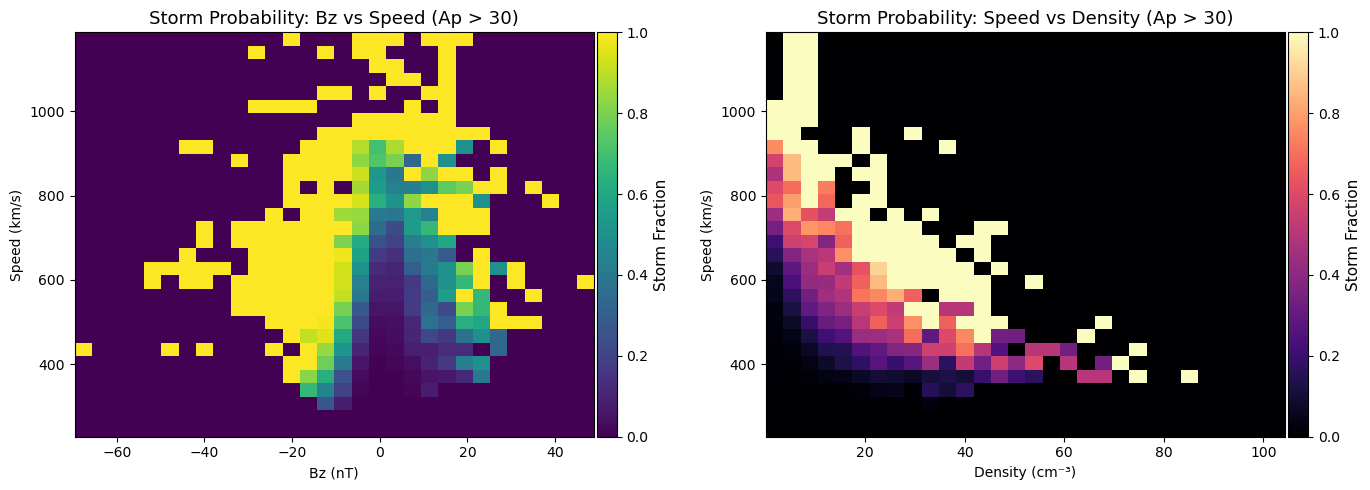

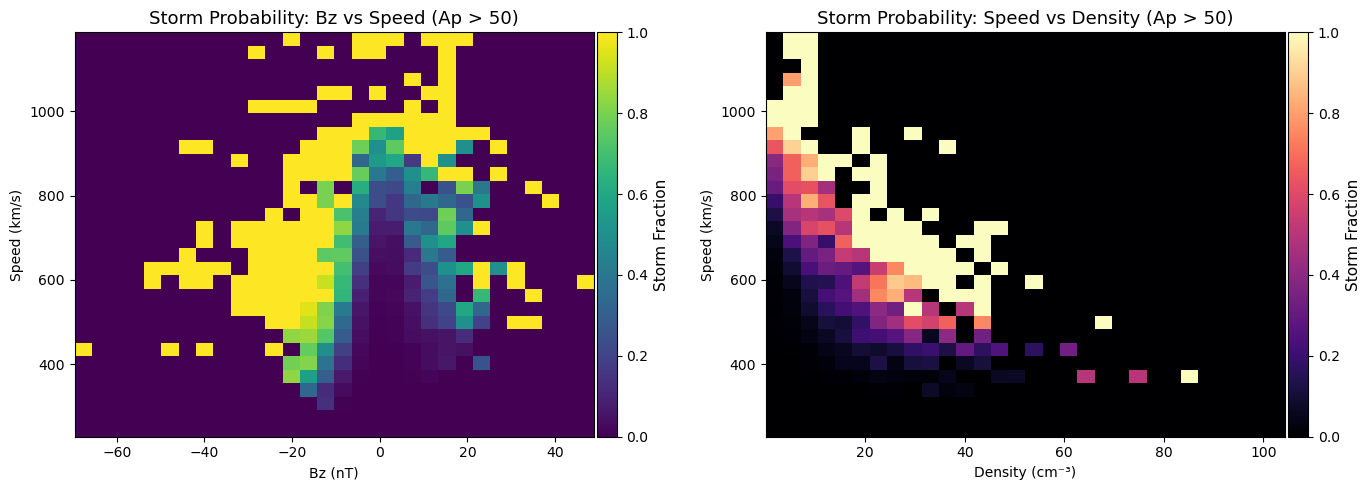

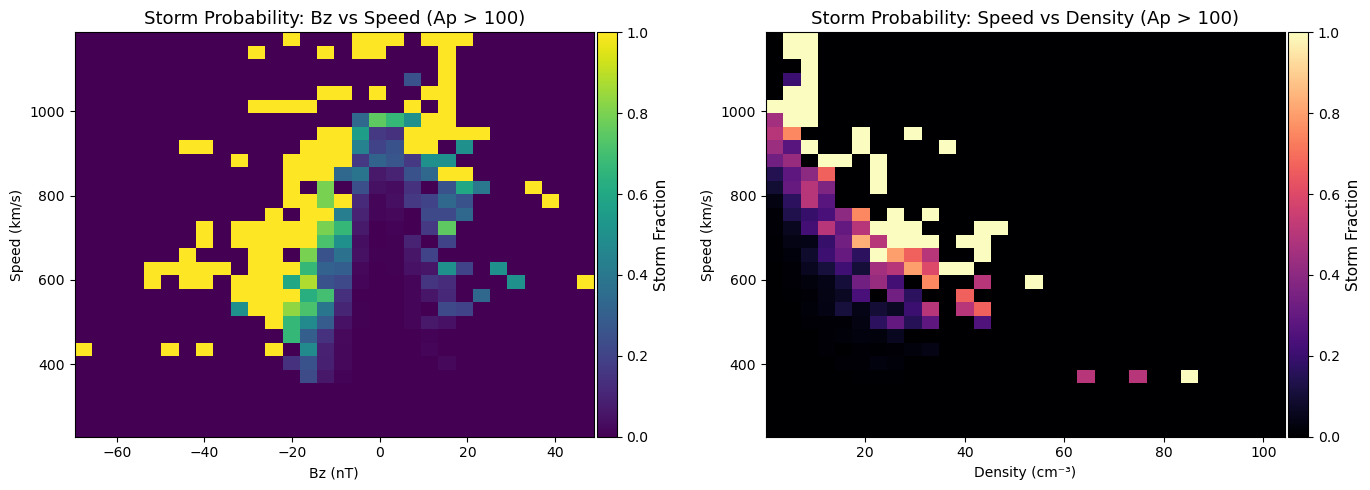

In [52]:
# Functions for plotting heatmaps
def compute_heatmap(x, y, z, bins = 30):

    H, xedges, yedges, _ = binned_statistic_2d(x, y, z, statistic = "mean", bins = bins)
    H = np.nan_to_num(H, nan = 0.0)

    return H.T, xedges, yedges


def plot_storm_heatmaps(df, target_col = "storm_ap", title_suffix = "Ap > 30", bins = 30):

    tmp = df[["Bz", "Speed", "Density", target_col]].dropna().copy()

    H1, bz_edges, spd_edges = compute_heatmap(tmp["Bz"], tmp["Speed"], tmp[target_col], bins = bins)
    H2, dens_edges, spd_edges2 = compute_heatmap(tmp["Density"], tmp["Speed"], tmp[target_col], bins = bins)

    fig, axes = plt.subplots(1, 2, figsize = (14, 5))
    plt.style.use("default")

    vmin = 0.0
    vmax = 1.0

    im1 = axes[0].imshow(H1, extent = [bz_edges.min(), bz_edges.max(), spd_edges.min(), spd_edges.max()],
                         origin = "lower", aspect = "auto", cmap = "viridis", vmin = vmin, vmax = vmax)

    axes[0].set_title(f"Storm Probability: Bz vs Speed ({title_suffix})", fontsize = 13)
    axes[0].set_xlabel("Bz (nT)")
    axes[0].set_ylabel("Speed (km/s)")
    axes[0].xaxis.set_major_locator(plt.MaxNLocator(6))
    axes[0].yaxis.set_major_locator(plt.MaxNLocator(6))

    cbar1 = plt.colorbar(im1, ax = axes[0], pad = 0.005)
    cbar1.set_label("Storm Fraction", fontsize = 11)

    im2 = axes[1].imshow(H2,extent = [dens_edges.min(), dens_edges.max(), spd_edges2.min(), spd_edges2.max()],
                         origin = "lower", aspect = "auto", cmap = "magma",vmin = vmin, vmax = vmax) 

    axes[1].set_title(f"Storm Probability: Speed vs Density ({title_suffix})", fontsize = 13)
    axes[1].set_xlabel("Density (cm⁻³)")
    axes[1].set_ylabel("Speed (km/s)")
    axes[1].xaxis.set_major_locator(plt.MaxNLocator(6))
    axes[1].yaxis.set_major_locator(plt.MaxNLocator(6))

    cbar2 = plt.colorbar(im2, ax = axes[1], pad = 0.005)
    cbar2.set_label("Storm Fraction", fontsize = 11)

    plt.tight_layout()
    plt.show()

# Plot
plot_storm_heatmaps(dfc, target_col = "storm_ap",    title_suffix = "Ap > 30")
plot_storm_heatmaps(dfc, target_col = "storm_ap50",  title_suffix = "Ap > 50")
plot_storm_heatmaps(dfc, target_col = "storm_ap100", title_suffix = "Ap > 100")